In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import shutil
import seaborn as sns
from scipy import stats
from ptm_dict import modres
from adjustText import adjust_text
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error as mae

In [2]:
# Block of seaborn style settings
plt.rc('font', size=23) #controls default text size
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

plt.rc('font', size=23) #controls default text size
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels

In [3]:
skempi2 = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_final.csv')
skempi2_raw = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi_v2.csv', sep=';')
skempi2_avg_nb = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_nb.csv')

In [4]:
exp_cart_ddG_all = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/cart_pipeline_full_struct.csv')

In [5]:
flex_ddg_gam = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/flex_ddg_gam_skempi2.csv')

In [6]:
flex_ddg_reg = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/flex_ddg_reg_skempi2.csv')

In [7]:
exp_cart_ddG_all_flex = pd.merge(exp_cart_ddG_all, flex_ddg_reg[['#Pdb', 'Mutation(s)_PDB', 'total_score']], on=['#Pdb', 'Mutation(s)_PDB'], how='left')

In [ ]:
display(exp_cart_ddG_all_flex.loc[exp_cart_ddG_all_flex['total_score'].isna()])

display(exp_cart_ddG_all.loc[(exp_cart_ddG_all['mean_ddG'].isna())&(exp_cart_ddG_all_flex['PDB_ID']!='3VR6')])

In [5]:
output_path = '/lustre/hpc/sbinlab/panf/SKEMPIv2_benchmark/cartesian_runs_folder/'
input_path = '/lustre/hpc/sbinlab/panf/SKEMPIv2_benchmark/benchmark_inputs/raw_PDBs'

In [85]:
## Loading the data

# Creating lists to store cart_ddG output stored as dfs
ddG_df_list_complex = list()
# Creating lists to store names of PDBs with empty output folders
no_output = list()
is_output = list()
# Going through contents of run dir
for folder in os.listdir(output_path):
    # If item is not a slurm file or a Jupyter checkpoint file, it's a folder with cart_ddG run files
    # Save path to 'output' folder in cart_ddG PDB run folder. This is the path to ddG_complex calculations.
    if not folder.startswith('.ipynb_'):
        path_to_output = os.path.join(output_path, folder, "output")
        path_to_pdb = os.path.join(output_path, folder)
        # If 'output' folder is not empty, read prism file, add PDBFileID column (by folder name), append list of dfs
        if len(os.listdir(path_to_output)) > 0:
            for file in os.listdir(path_to_output):
                # if file.startswith('prism_rosetta_'):
                #     if not file.endswith('-gap.txt'):
                #         path_to_prism = os.path.join(path_to_output, file)
                #         x = pd.read_csv(path_to_prism, sep=" ", comment='#')
                #         x['PDB_ID'] = folder
                #         ddG_df_list_complex.append(x)
                if file.endswith('_full_interface_IAM_single_load.csv'):
                    path_to_prism = os.path.join(path_to_output, file)
                    x = pd.read_csv(path_to_prism)
                    x['PDB_ID'] = folder
                    ddG_df_list_complex.append(x)
                    is_output.append(folder)
                        
        # If 'output' folder is empty, add PDB name to no_output list
        else:
            no_output.append(folder)

# Concatenate list of dfs into one for ddG_complex
all_cases_muts = pd.concat(ddG_df_list_complex)
variants = all_cases_muts[~all_cases_muts.variant.str.contains(r'=')].copy()
variants.reset_index(drop=True, inplace=True)
no_output.sort()

print('No output for the following PDB IDs: ', no_output)
print('The following PDB IDs from SKEMPI v2 are not in the output: ')
for pdb_id in skempi2.PDB_ID.unique():
    if not pdb_id in os.listdir(output_path):
        print(pdb_id)
    if not pdb_id in is_output:
        print('IA problem: ', pdb_id)

No output for the following PDB IDs:  ['3VR6']
The following PDB IDs from SKEMPI v2 are not in the output: 
3SE3
IA problem:  3SE3
3SE4
IA problem:  3SE4
IA problem:  3VR6
2C5D
IA problem:  2C5D


In [86]:
# Renumbering the residues from Rosetta numeration to chain + num for the whole PDB

dict_of_dicts = {}
for folder_pdb in os.listdir(output_path):
    if not (folder_pdb.endswith('.ipynb_checkpoints')) or (folder_pdb.startswith('slurm-')):
        for item in os.listdir(os.path.join(output_path, folder_pdb)):
            if item.endswith('.sbatch'):
                if not item.endswith(('IA_calc.sbatch', 'IA_calc_wt.sbatch', 'IA_calc_satmut.sbatch')):
                    chains = item.split('.')[0].split('_')[2]
        
        pdb_path = os.path.join(output_path, folder_pdb, 'prepare', 'input', 'input.pdb')
        
        pdb_file = open(pdb_path, 'r')
        lines = pdb_file.readlines()
        raa_prev = ''
        rn_pres = ''
        pos_chain = {}
        pos_add = 1
        for line in lines:
            if folder_pdb == '1DAN':
                if line.startswith('ATOM'):
                    if line[21] in chains:
                        if (line[17:20] != raa_prev)|(line[22:27] != rn_pres):
                            chain_num = line[21] + ' ' + line[22:27].strip(' ').lower()
                            pos_chain[chain_num] = pos_add
                            raa_prev = line[17:20]
                            rn_pres = line[22:27]
                            pos_add += 1
                            
            else:
                if line.startswith('ATOM') | line.startswith('HETATM'):
                    if line[17:20] in modres.keys():
                        if line[21] in chains:
                            if (line[17:20] != raa_prev)|(line[22:27] != rn_pres):
                                chain_num = line[21] + ' ' + line[22:27].strip(' ').lower()
                                pos_chain[chain_num] = pos_add
                                raa_prev = line[17:20]
                                rn_pres = line[22:27]
                                pos_add += 1
        pdb_file.close()
        dict_of_dicts[folder_pdb] = pos_chain

In [88]:
# Renumbering resfile notation to prism output notation

dict_mult_interface = {'2C5D_AB_CD':'2C5D_ABCD_ABCD', '2C5D_A_C':'2C5D_C_AC',
                       '3SE3_B_C':'3SE3_B_BC', '3SE3_B_A':'3SE3_BA_BA',
                       '3SE4_B_A':'3SE4_AB_BA', '3SE4_B_C':'3SE4_CB_BC'}

dict_mult_interface_rev = {'2C5D_ABCD_ABCD':'2C5D_AB_CD', '2C5D_C_AC':'2C5D_A_C',
                       '3SE3_B_BC':'3SE3_B_C', '3SE3_BA_BA':'3SE3_B_A',
                       '3SE4_AB_BA':'3SE4_B_A', '3SE4_CB_BC':'3SE4_B_C'}

# Go through the dataframe row by row. Get PDB id for every case and mutations as a list. Define list to append reformated mutations to.
reformat_muts = list()
for index, row in skempi2.iterrows():
    # pdb_list = list()
    pdb = row['PDB_ID']
    pdb_c = row['#Pdb']
    
    if pdb.startswith(('2C5D', '3SE3', '3SE4')):
        pdb = dict_mult_interface[pdb_c]
    #     for file in os.listdir(os.path.join(input_path, pdb)):
    #         if file.endswith('.txt'):
    #             pdb_list.append(file.split('.')[0])
    # else:
    #     pdb_list.append(row['PDB_ID'])

    # for pdb in pdb_list:
                
    list_mut = row['Mutation(s)_PDB'].split(',')
    # string_full_mut = ''
    list_full_mut = list()
    count = 0
# Go through mutations and append reformated mutations to the list
    for mut in list_mut:
        count += 1
        pos = mut[2:-1]
        chain = mut[1]
        sub = mut[-1]     
        wt = mut[0]
        word = chain + ' ' + pos
        # For every mutation, look in the dictionary for chain plus position and translate to Rosetta numeration
        try:
            translation = str(dict_of_dicts[pdb][word])
        except:
            print(pdb, word, '-- zero occupancy issue')
        prism_format = wt + translation + sub
        if prism_format not in list_full_mut:
            list_full_mut.append(prism_format)
    list_full_mut.sort(key = lambda x: int(x[1:-1]))
    delim = ":"
    # using map to convert each element to string
    temp = list(map(str, list_full_mut))
    # join() used to join with delimiter
    string_full_mut = delim.join(temp)
    reformat_muts.append(string_full_mut)

1JCK B 103 -- zero occupancy issue
1JCK B 102 -- zero occupancy issue
1AK4 D 496 -- zero occupancy issue


In [89]:
skempi2['variant'] = reformat_muts
exp_cart_ddG_all = pd.merge(variants, skempi2, on=['PDB_ID', 'variant'], how='right')

for index, row in exp_cart_ddG_all.iterrows():
    if row['#Pdb'] in dict_mult_interface.keys():
        
        ddG_value = variants.loc[(variants['PDB_ID'] == dict_mult_interface[row['#Pdb']]
                     )&(variants['variant'] == row['variant'])]['mean_ddG'].values[0]
        std_value = variants.loc[(variants['PDB_ID'] == dict_mult_interface[row['#Pdb']]
                     )&(variants['variant'] == row['variant'])]['std_ddG'].values[0]

        # print('mean ddG', exp_cart_ddG_all.iloc[index, 1], ddG_value)
        # print('std', exp_cart_ddG_all.iloc[index, 2], std_value)
        # count += 1
        exp_cart_ddG_all.iloc[index, 1] = ddG_value
        exp_cart_ddG_all.iloc[index, 2] = std_value
        
exp_cart_ddG_all.loc[exp_cart_ddG_all['mean_ddG']>15, 'mean_ddG'] = 15
exp_cart_ddG_all['N_mut'] = exp_cart_ddG_all['variant'].str.split(':').str.len()
exp_cart_ddG_all['N_mut'] = exp_cart_ddG_all['N_mut'].apply(lambda x: '3+' if x >= 3 else x)
exp_cart_ddG_all['N_mut'] = exp_cart_ddG_all['N_mut'].apply(str)
#exp_cart_ddG_all.to_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/cart_pipeline_full_struct.csv', index=False)

In [91]:
# Renumbering resfile notation to prism output notation

dict_mult_interface = {'2C5D_AB_CD':'2C5D_ABCD_ABCD', '2C5D_A_C':'2C5D_C_AC',
                       '3SE3_B_C':'3SE3_B_BC', '3SE3_B_A':'3SE3_BA_BA',
                       '3SE4_B_A':'3SE4_AB_BA', '3SE4_B_C':'3SE4_CB_BC'}

dict_mult_interface_rev = {'2C5D_ABCD_ABCD':'2C5D_AB_CD', '2C5D_C_AC':'2C5D_A_C',
                       '3SE3_B_BC':'3SE3_B_C', '3SE3_BA_BA':'3SE3_B_A',
                       '3SE4_AB_BA':'3SE4_B_A', '3SE4_CB_BC':'3SE4_B_C'}

# Go through the dataframe row by row. Get PDB id for every case and mutations as a list. Define list to append reformated mutations to.
reformat_muts_nb = list()
for index, row in skempi2_avg_nb.iterrows():
    # pdb_list = list()
    #pdb = row['PDB_ID']
    pdb = row['PDB_ID'][0:4]
    pdb_c = row['#Pdb']
    
    if pdb.startswith(('2C5D', '3SE3', '3SE4')):
        pdb = dict_mult_interface[pdb_c]
    #     for file in os.listdir(os.path.join(input_path, pdb)):
    #         if file.endswith('.txt'):
    #             pdb_list.append(file.split('.')[0])
    # else:
    #     pdb_list.append(row['PDB_ID'])

    # for pdb in pdb_list:
                
    list_mut = row['Mutation(s)_PDB'].split(',')
    # string_full_mut = ''
    list_full_mut = list()
    count = 0
# Go through mutations and append reformated mutations to the list
    for mut in list_mut:
        count += 1
        pos = mut[2:-1]
        chain = mut[1]
        sub = mut[-1]     
        wt = mut[0]
        word = chain + ' ' + pos
        # For every mutation, look in the dictionary for chain plus position and translate to Rosetta numeration
        try:
            translation = str(dict_of_dicts[pdb][word])
        except:
            print(pdb, word, '-- zero occupancy issue')
        prism_format = wt + translation + sub
        if prism_format not in list_full_mut:
            list_full_mut.append(prism_format)
    list_full_mut.sort(key = lambda x: int(x[1:-1]))
    delim = ":"
    # using map to convert each element to string
    temp = list(map(str, list_full_mut))
    # join() used to join with delimiter
    string_full_mut = delim.join(temp)
    reformat_muts_nb.append(string_full_mut)

skempi2_avg_nb['variant'] = reformat_muts_nb
exp_cart_ddG_nb = pd.merge(variants, skempi2_avg_nb, on=['PDB_ID', 'variant'], how='right')

for index, row in exp_cart_ddG_nb.iterrows():
    if row['#Pdb'] in dict_mult_interface.keys():
        
        ddG_value = variants.loc[(variants['PDB_ID'] == dict_mult_interface[row['#Pdb']]
                     )&(variants['variant'] == row['variant'])]['mean_ddG'].values[0]
        std_value = variants.loc[(variants['PDB_ID'] == dict_mult_interface[row['#Pdb']]
                     )&(variants['variant'] == row['variant'])]['std_ddG'].values[0]

        # print('mean ddG', exp_cart_ddG_all.iloc[index, 1], ddG_value)
        # print('std', exp_cart_ddG_all.iloc[index, 2], std_value)
        # count += 1
        exp_cart_ddG_nb.iloc[index, 1] = ddG_value
        exp_cart_ddG_nb.iloc[index, 2] = std_value
        
exp_cart_ddG_nb.loc[exp_cart_ddG_nb['mean_ddG']>15, 'mean_ddG'] = 15
exp_cart_ddG_nb['N_mut'] = exp_cart_ddG_nb['variant'].str.split(':').str.len()
exp_cart_ddG_nb['N_mut'] = exp_cart_ddG_nb['N_mut'].apply(lambda x: '3+' if x >= 3 else x)
exp_cart_ddG_nb['N_mut'] = exp_cart_ddG_nb['N_mut'].apply(str)
#exp_cart_ddG_all.to_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/cart_pipeline_full_struct.csv', index=False)

In [94]:
exp_cart_ddG_all_nb = pd.concat([exp_cart_ddG_all, exp_cart_ddG_nb])

In [6]:
exp_cart_ddG_all_nb = exp_cart_ddG_all.copy()
exp_cart_ddG_all_nb.loc[exp_cart_ddG_all_nb['no_proper_value']=='no binding MUT', 'dG_bind_MUT'] = -1.5
exp_cart_ddG_all_nb['ddG_bind'] = exp_cart_ddG_all_nb['dG_bind_MUT'].values - exp_cart_ddG_all_nb['dG_bind_WT'].values

exp_cart_ddG_all_no_nan = exp_cart_ddG_all.copy().dropna(subset=['ddG_bind', 'mean_ddG', 'mean_ddG_infc'])
#exp_cart_ddG_all_no_nan = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['no_proper_value']=='Regular']

In [7]:
pdb_list = ['1JTG', '5E9D', '3SZK', '3BN9', '2J0T', '1KTZ', '3SGB', '3MZG', '1DAN', '1VFB', '1OGA', "1PPF",  "1AO7", "1CHO", "1R0R", "1MHP", "3HFM", "1KNE", "2JEL", "2FTL", "1IAR"]
H_dataset = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['PDB_ID'].isin(pdb_list)]
H_dataset = H_dataset.loc[H_dataset['N_mut']=='1']
H_dataset.to_csv('H_subset_SKEMPI_2_xtal_Cart_ddG_IA.csv', index=False)
#H_dataset = H_dataset.loc[H_dataset['Small-to-large']]

In [8]:
exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['Hold_out_type'].isna(), 'Hold_out_type'] = 'None'

In [9]:
exp_cart_ddG_all_no_nan.Hold_out_type.unique()

array(['Pr/PI', 'None', 'AB/AG', 'AB/AG,Pr/PI', 'TCR/pMHC'], dtype=object)

In [10]:
S2536 = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/S2536.csv', sep=';')

In [11]:
S2536_sub = pd.merge(S2536, exp_cart_ddG_all_nb[['variant', 'mean_ddG', 'std_ddG',
                                              'mean_ddG_infc', 'std_ddG_infc', 'PDB_ID',
                                              'case_ID', 'Mutation(s)_PDB', 'ddG_bind', 
                                              'small-to-large', 'type_of_change_infc',
                                              'type_of_change_aa', 'N_mut',
                                              'multiple_measurements', 'no_proper_value',
                                              'Method',
                                              'LChains',	'RChains',	'Chains']], left_on=['PDB', 'Mutation(s)_in_raw_pdb'], right_on=['PDB_ID', 'Mutation(s)_PDB'], how='left')

Text(0.5, 0.98, 'Cartesian ddG + InterfaceAnalyzer')

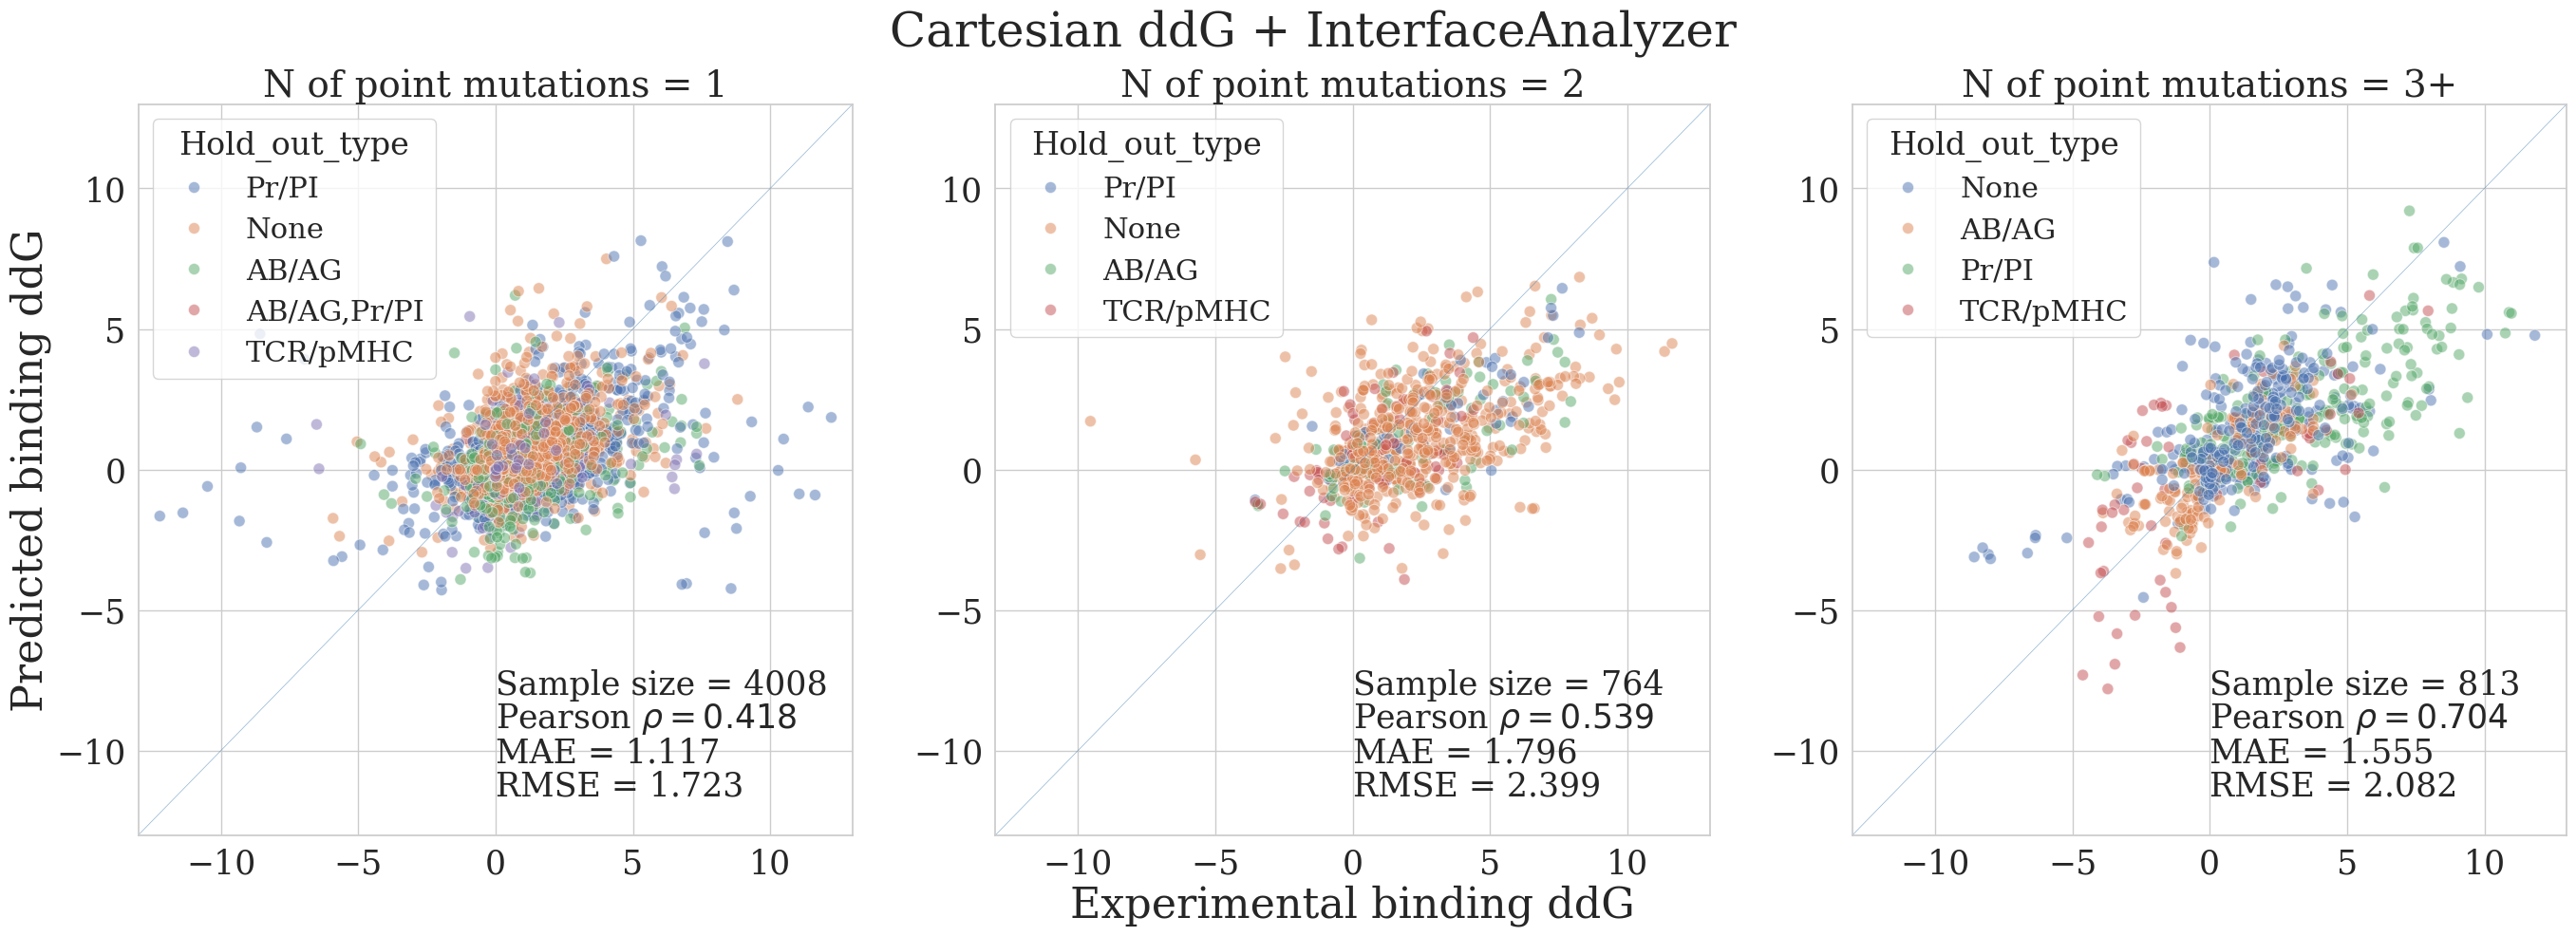

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-13, 13), ylim=(-13, 13))
# Loop through the data and axes, and plot each scatter plot
for ax, N in zip(axs, exp_cart_ddG_all_no_nan['N_mut'].unique()):
    subset = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']==N]
    sns.scatterplot(data=subset, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=75,
                       hue='Hold_out_type', ax=ax)
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)

    ax.annotate(f'Sample size = {len(subset)}', xy=(0, -8), fontsize = 25)
    r, p = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(0, -9.2), fontsize = 25)
    error = mae(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'MAE = {error:.3f}', xy=(0, -10.4), fontsize = 25)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset['mean_ddG_infc']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(0, -11.6), fontsize = 25)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'N of point mutations = {N}', fontsize = 28)
    
axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=36)

#plt.savefig('Figures/cart_ddG_IA_hot.pdf', format='pdf')

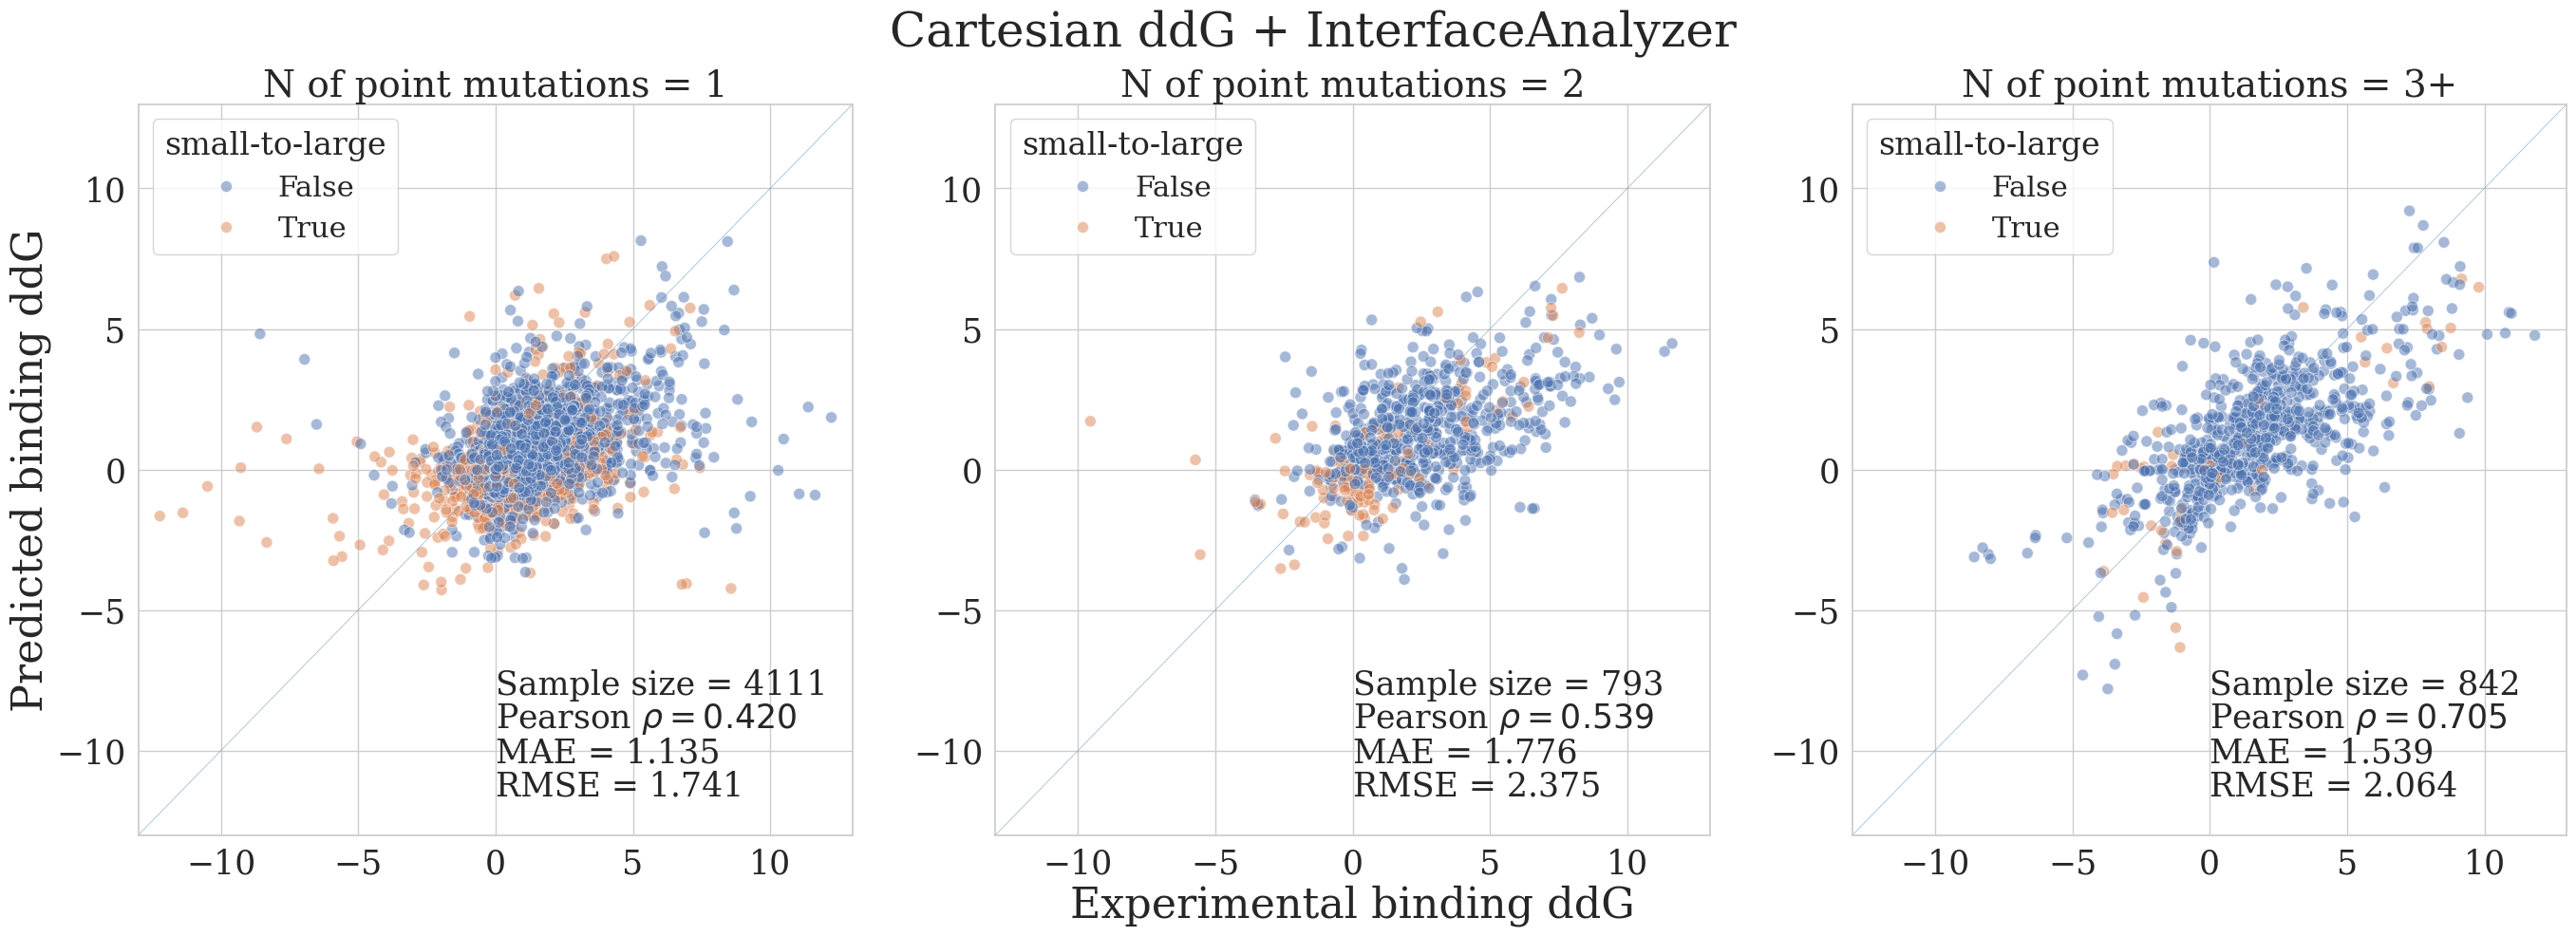

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-13, 13), ylim=(-13, 13))
# Loop through the data and axes, and plot each scatter plot
for ax, N in zip(axs, exp_cart_ddG_all_no_nan['N_mut'].unique()):
    subset = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']==N]
    sns.scatterplot(data=subset, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=75,
                       hue='small-to-large', ax=ax)
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)

    ax.annotate(f'Sample size = {len(subset)}', xy=(0, -8), fontsize = 25)
    r, p = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(0, -9.2), fontsize = 25)
    error = mae(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'MAE = {error:.3f}', xy=(0, -10.4), fontsize = 25)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset['mean_ddG_infc']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(0, -11.6), fontsize = 25)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'N of point mutations = {N}', fontsize = 28)
    
axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=36)

plt.savefig('Figures/cart_ddG_IA_stl.pdf', format='pdf')

In [35]:
palette_colors = sns.color_palette('tab10')
palette_dict = {'infc to non-infc':'blue', 'infc to infc':'orange', 'non-infc to infc':'green', 'non-infc to non-infc':'red', 'mixed':'purple'}

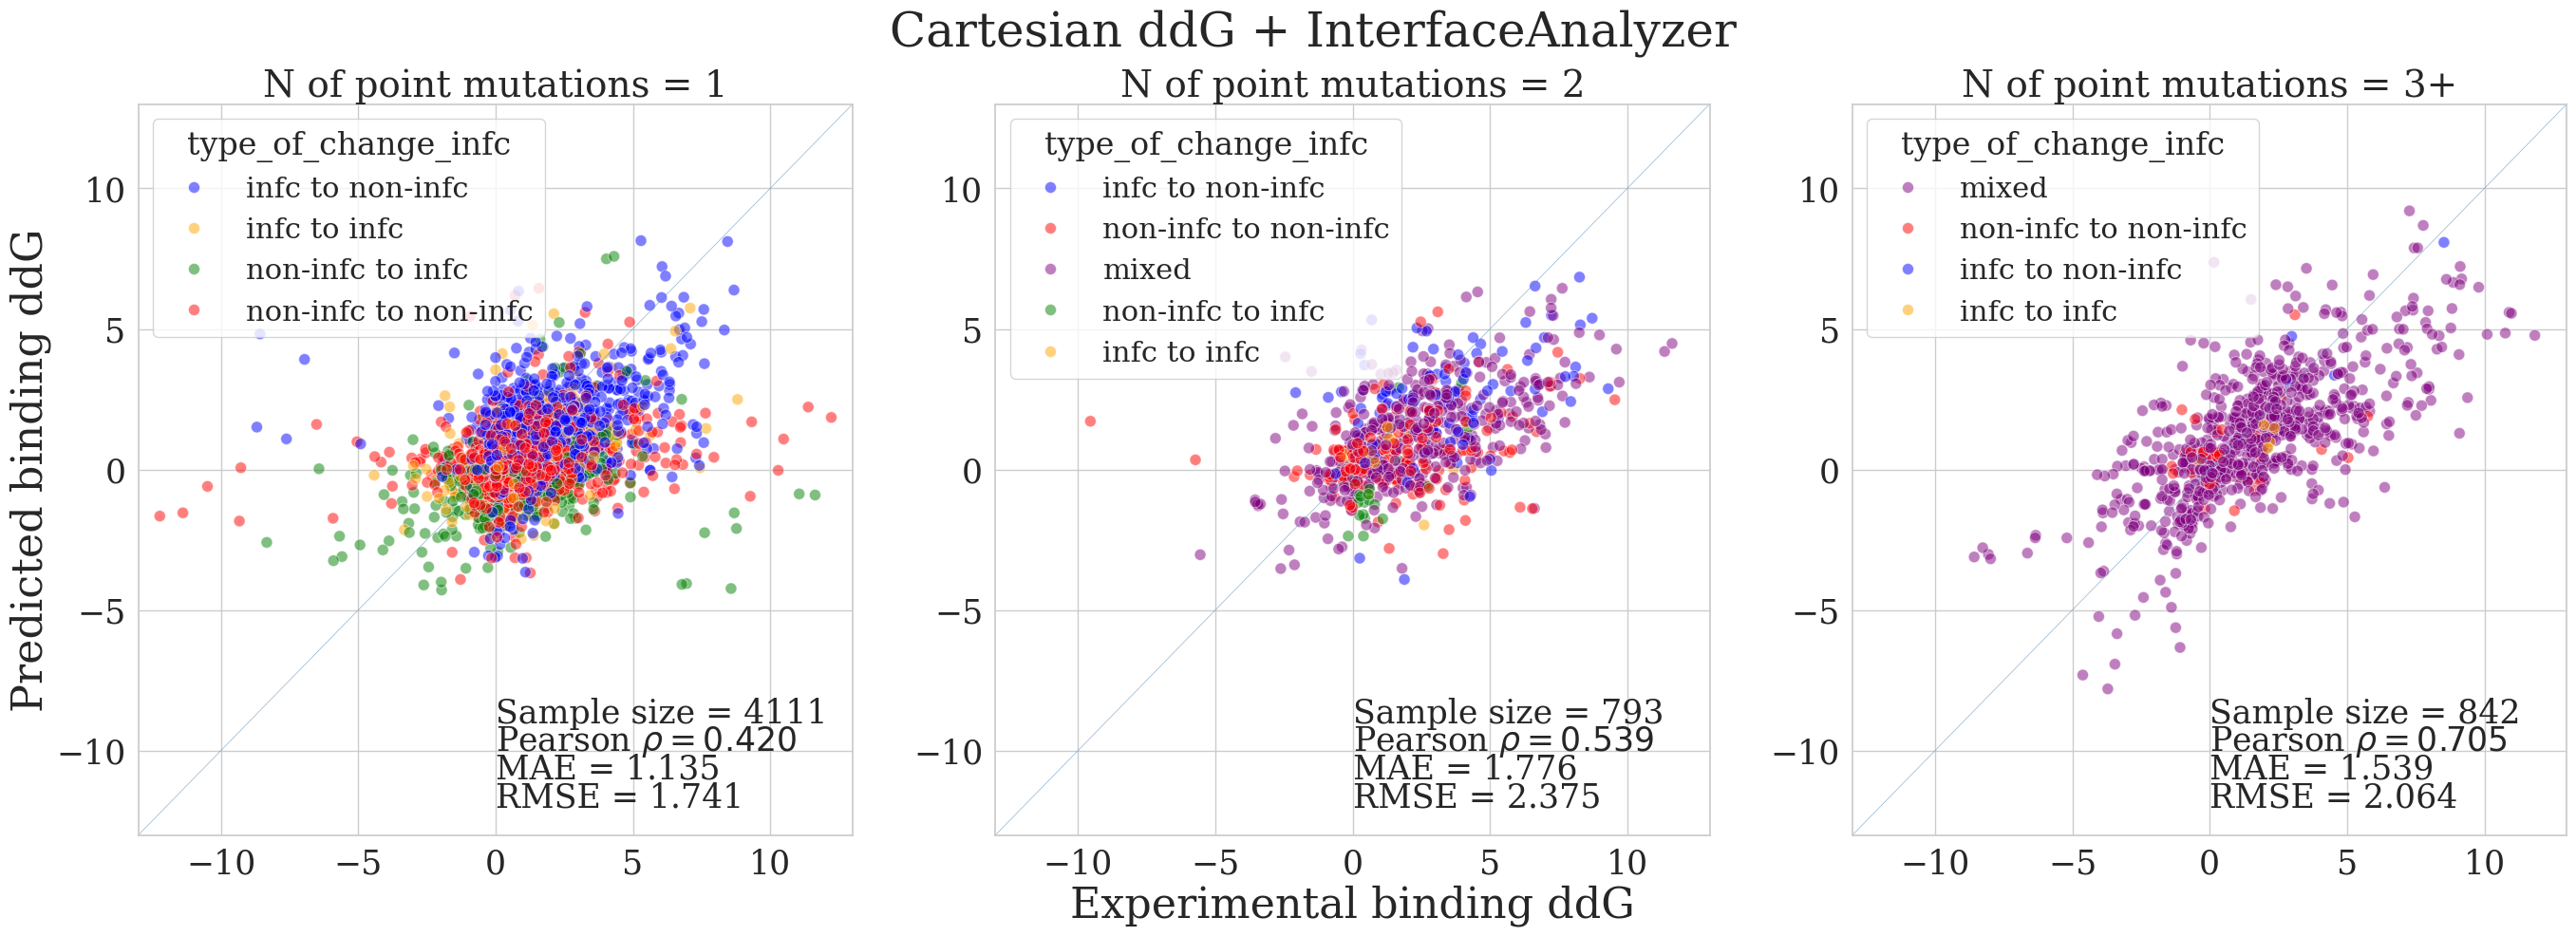

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-13, 13), ylim=(-13, 13))
# Loop through the data and axes, and plot each scatter plot
for ax, N in zip(axs, exp_cart_ddG_all_no_nan['N_mut'].unique()):
    subset = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']==N]
    sns.scatterplot(data=subset, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=75,
                       hue='type_of_change_infc',
                       ax=ax, palette=palette_dict)
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)

    ax.annotate(f'Sample size = {len(subset)}', xy=(0, -9), fontsize = 25)
    r, p = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(0, -10), fontsize = 25)
    error = mae(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'MAE = {error:.3f}', xy=(0, -11), fontsize = 25)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset['mean_ddG_infc']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(0, -12), fontsize = 25)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'N of point mutations = {N}', fontsize = 28)
    sns.move_legend(ax, "upper left")
    
axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=36)

plt.savefig('Figures/cart_ddG_IA_type_of_change.pdf', format='pdf')

In [9]:
outliers = exp_cart_ddG_all_no_nan.loc[abs(exp_cart_ddG_all_no_nan['ddG_bind']-exp_cart_ddG_all_no_nan['mean_ddG_infc'])>4]

In [ ]:
lol = exp_cart_ddG_all_no_nan.copy()
lol['cdg^2+IA'] = 

In [ ]:
fig= plt.figure(figsize=(10, 10))
sns.histplot(data=exp_cart_ddG_all_no_nan, x="ddG_bind", bins=180, color='r', alpha = 1, label='SKEMPI 2.0')
sns.histplot(data=exp_cart_ddG_all_no_nan, x="cdg^2+IA", bins=180, color='b', alpha = 0.7, label='cart_ddg+IA+cart_ddg')

plt.xlabel('Binding ddG')

plt.legend(fontsize=21)
plt.savefig("Figures/ddG_bind_dist_lol.pdf", format='pdf')

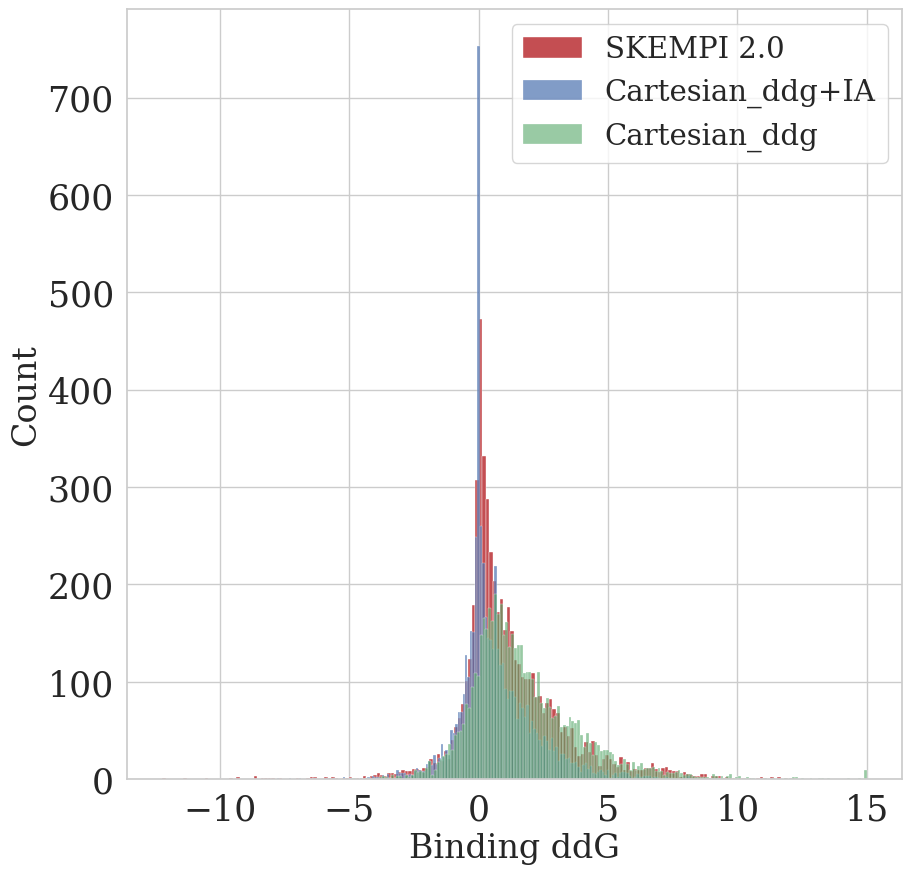

In [27]:
fig= plt.figure(figsize=(10, 10))
sns.histplot(data=exp_cart_ddG_all_no_nan, x="ddG_bind", bins=180, color='r', alpha = 1, label='SKEMPI 2.0')
sns.histplot(data=exp_cart_ddG_all_no_nan, x="mean_ddG_infc", bins=180, color='b', alpha = 0.7, label='Cartesian_ddg+IA')
sns.histplot(data=exp_cart_ddG_all_no_nan, x="mean_ddG", bins=180, color='g', alpha = 0.6, label='Cartesian_ddg')

plt.xlabel('Binding ddG')

plt.legend(fontsize=21)
plt.savefig("Figures/ddG_bind_dist_CartIA_Cart_Exp.pdf", format='pdf')

In [17]:
exp_cart_ddG_all_no_nan.Method.value_counts()

Method
SPR         2032
FL          1350
ITC          420
IASP         387
SFFL         293
RA           261
SP           190
ELISA        152
IAFL         145
KinExA       103
IARA          89
BI            49
CSPRIA        40
ELFA          25
ESMA          17
SPR,SFFL      10
SFPF          10
IAGE           8
EMSA           6
Name: count, dtype: int64

In [ ]:
list_of_lists = [['SPR', 'FL', 'ITC', 'SP'], ['RA', 'IASP', 'SFFL', 'ELISA', 'IAFL', 'KinExA'],
                 ['IARA', 'BI', 'CSPRIA', 'ELFA', 'ESMA'], ['SPR,SFFL', 'SFPF', 'IAGE', 'EMSA']]

In [48]:
list_of_lists = [['SPR', 'FL', 'ITC'], ['SP', 'SFFL'],
                 ['ELISA', 'RA'], ['KinExA', 'BI', 'CSPRIA', 'ELFA'],
                 ['IASP', 'IAFL'], ['IARA', 'IAGE']]

In [64]:
list_of_lists = [['SPR', 'FL', 'ITC'], ['ELISA', 'RA'],
                 ['SP', 'SFFL'], ['IASP', 'IAFL'],
                 ['KinExA', 'BI', 'CSPRIA', 'ELFA'], ['IARA', 'IAGE']]

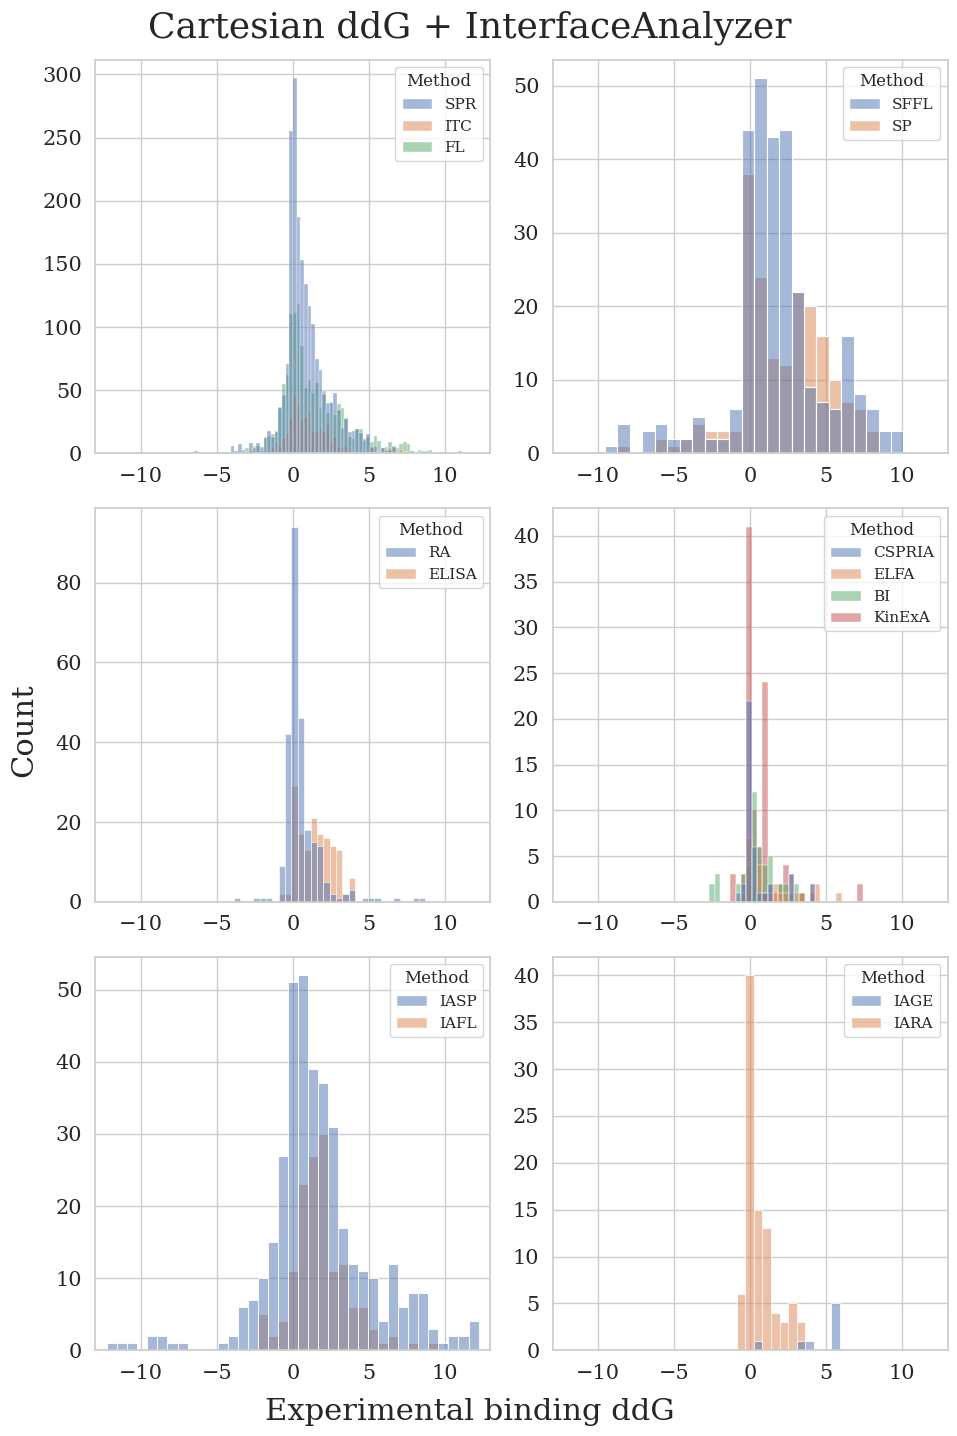

In [58]:
plt.rc('font', size=15) #controls default text size
plt.rc('xtick', labelsize=15) #fontsize of the x tick labels
plt.rc('ytick', labelsize=15) #fontsize of the y tick labels
#sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=1)

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
plt.setp(axes, xlim=(-13, 13))
axes = axes.flatten()
df = exp_cart_ddG_all_no_nan.copy()
for ax, l in zip(axes, list_of_lists):
    subset = df.loc[df['Method'].isin(l)]
    a = sns.histplot(data=subset, x="ddG_bind", hue='Method', ax=ax, alpha=0.5)
    #a.set_title(sub, fontsize=25)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.text(0.5, 0.04, 'Experimental binding ddG', ha='center', fontsize=22)
fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical', fontsize=22)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=26)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('Figures/cart_ddG_IA_method_hist.pdf', format='pdf')

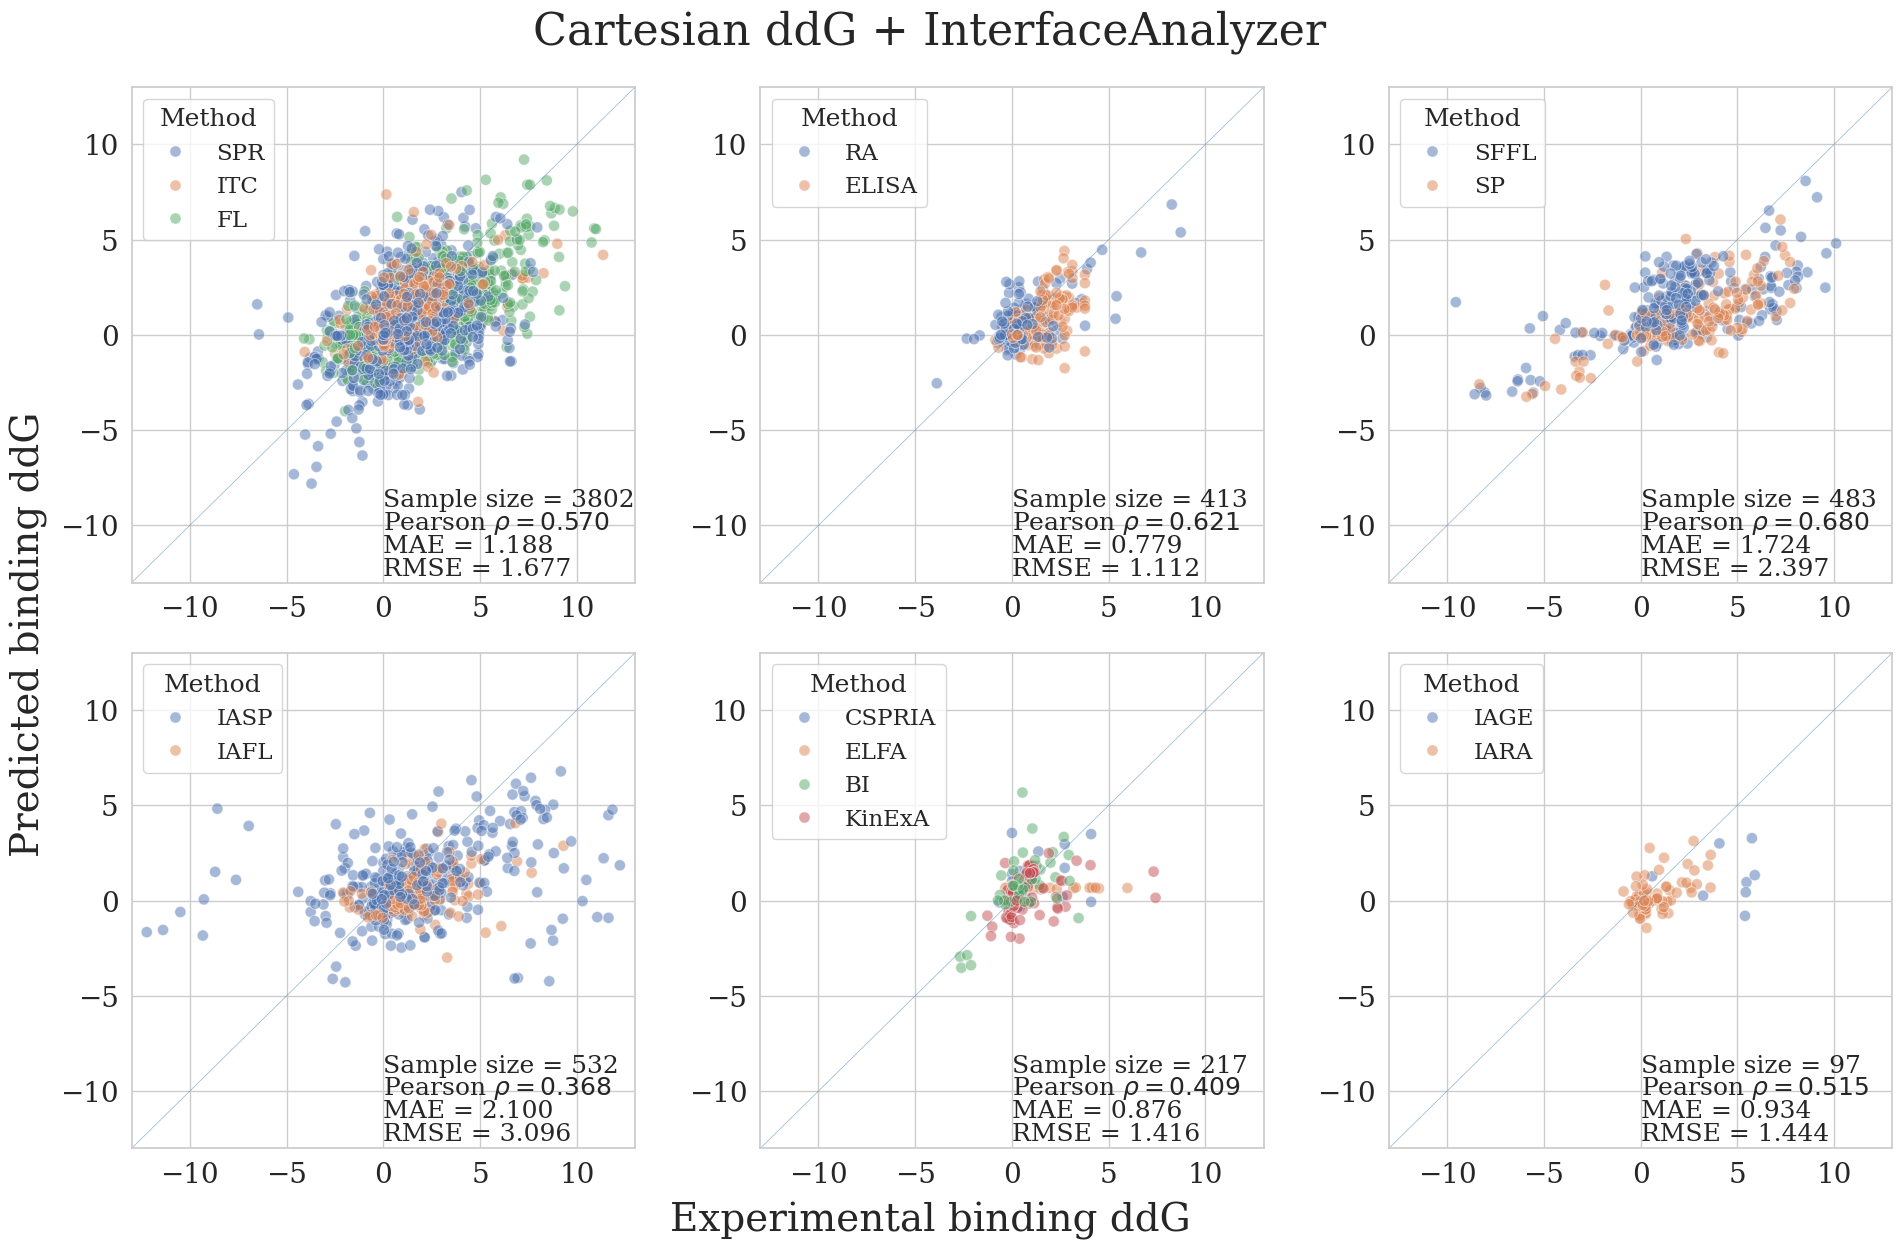

In [70]:
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=1.5)
plt.rc('font', size=20) #controls default text size
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels


fig, axes = plt.subplots(2, 3, figsize=(20, 13))
plt.setp(axes, xlim=(-13, 13), ylim=(-13, 13))
axes = axes.flatten()

for ax, l in zip(axes, list_of_lists):
    subset = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['Method'].isin(l)]
    sns.scatterplot(data=subset, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=65,
                       hue='Method',
                       ax=ax)
    
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    ax.annotate(f'Sample size = {len(subset)}', xy=(0, -9), fontsize = 18)
    r, p = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(0, -10.2), fontsize = 18)
    error = mae(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'MAE = {error:.3f}', xy=(0, -11.4), fontsize = 18)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset['mean_ddG_infc']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(0, -12.6), fontsize = 18)
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_title(f'N of point mutations = {N}', fontsize = 28)
    sns.move_legend(ax, "upper left")
    
fig.text(0.5, 0.04, 'Experimental binding ddG', ha='center', fontsize=28)  # x label
fig.text(0.04, 0.5, 'Predicted binding ddG', va='center', rotation='vertical', fontsize=28)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=32)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('Figures/cart_ddG_IA_method_x6.pdf', format='pdf')

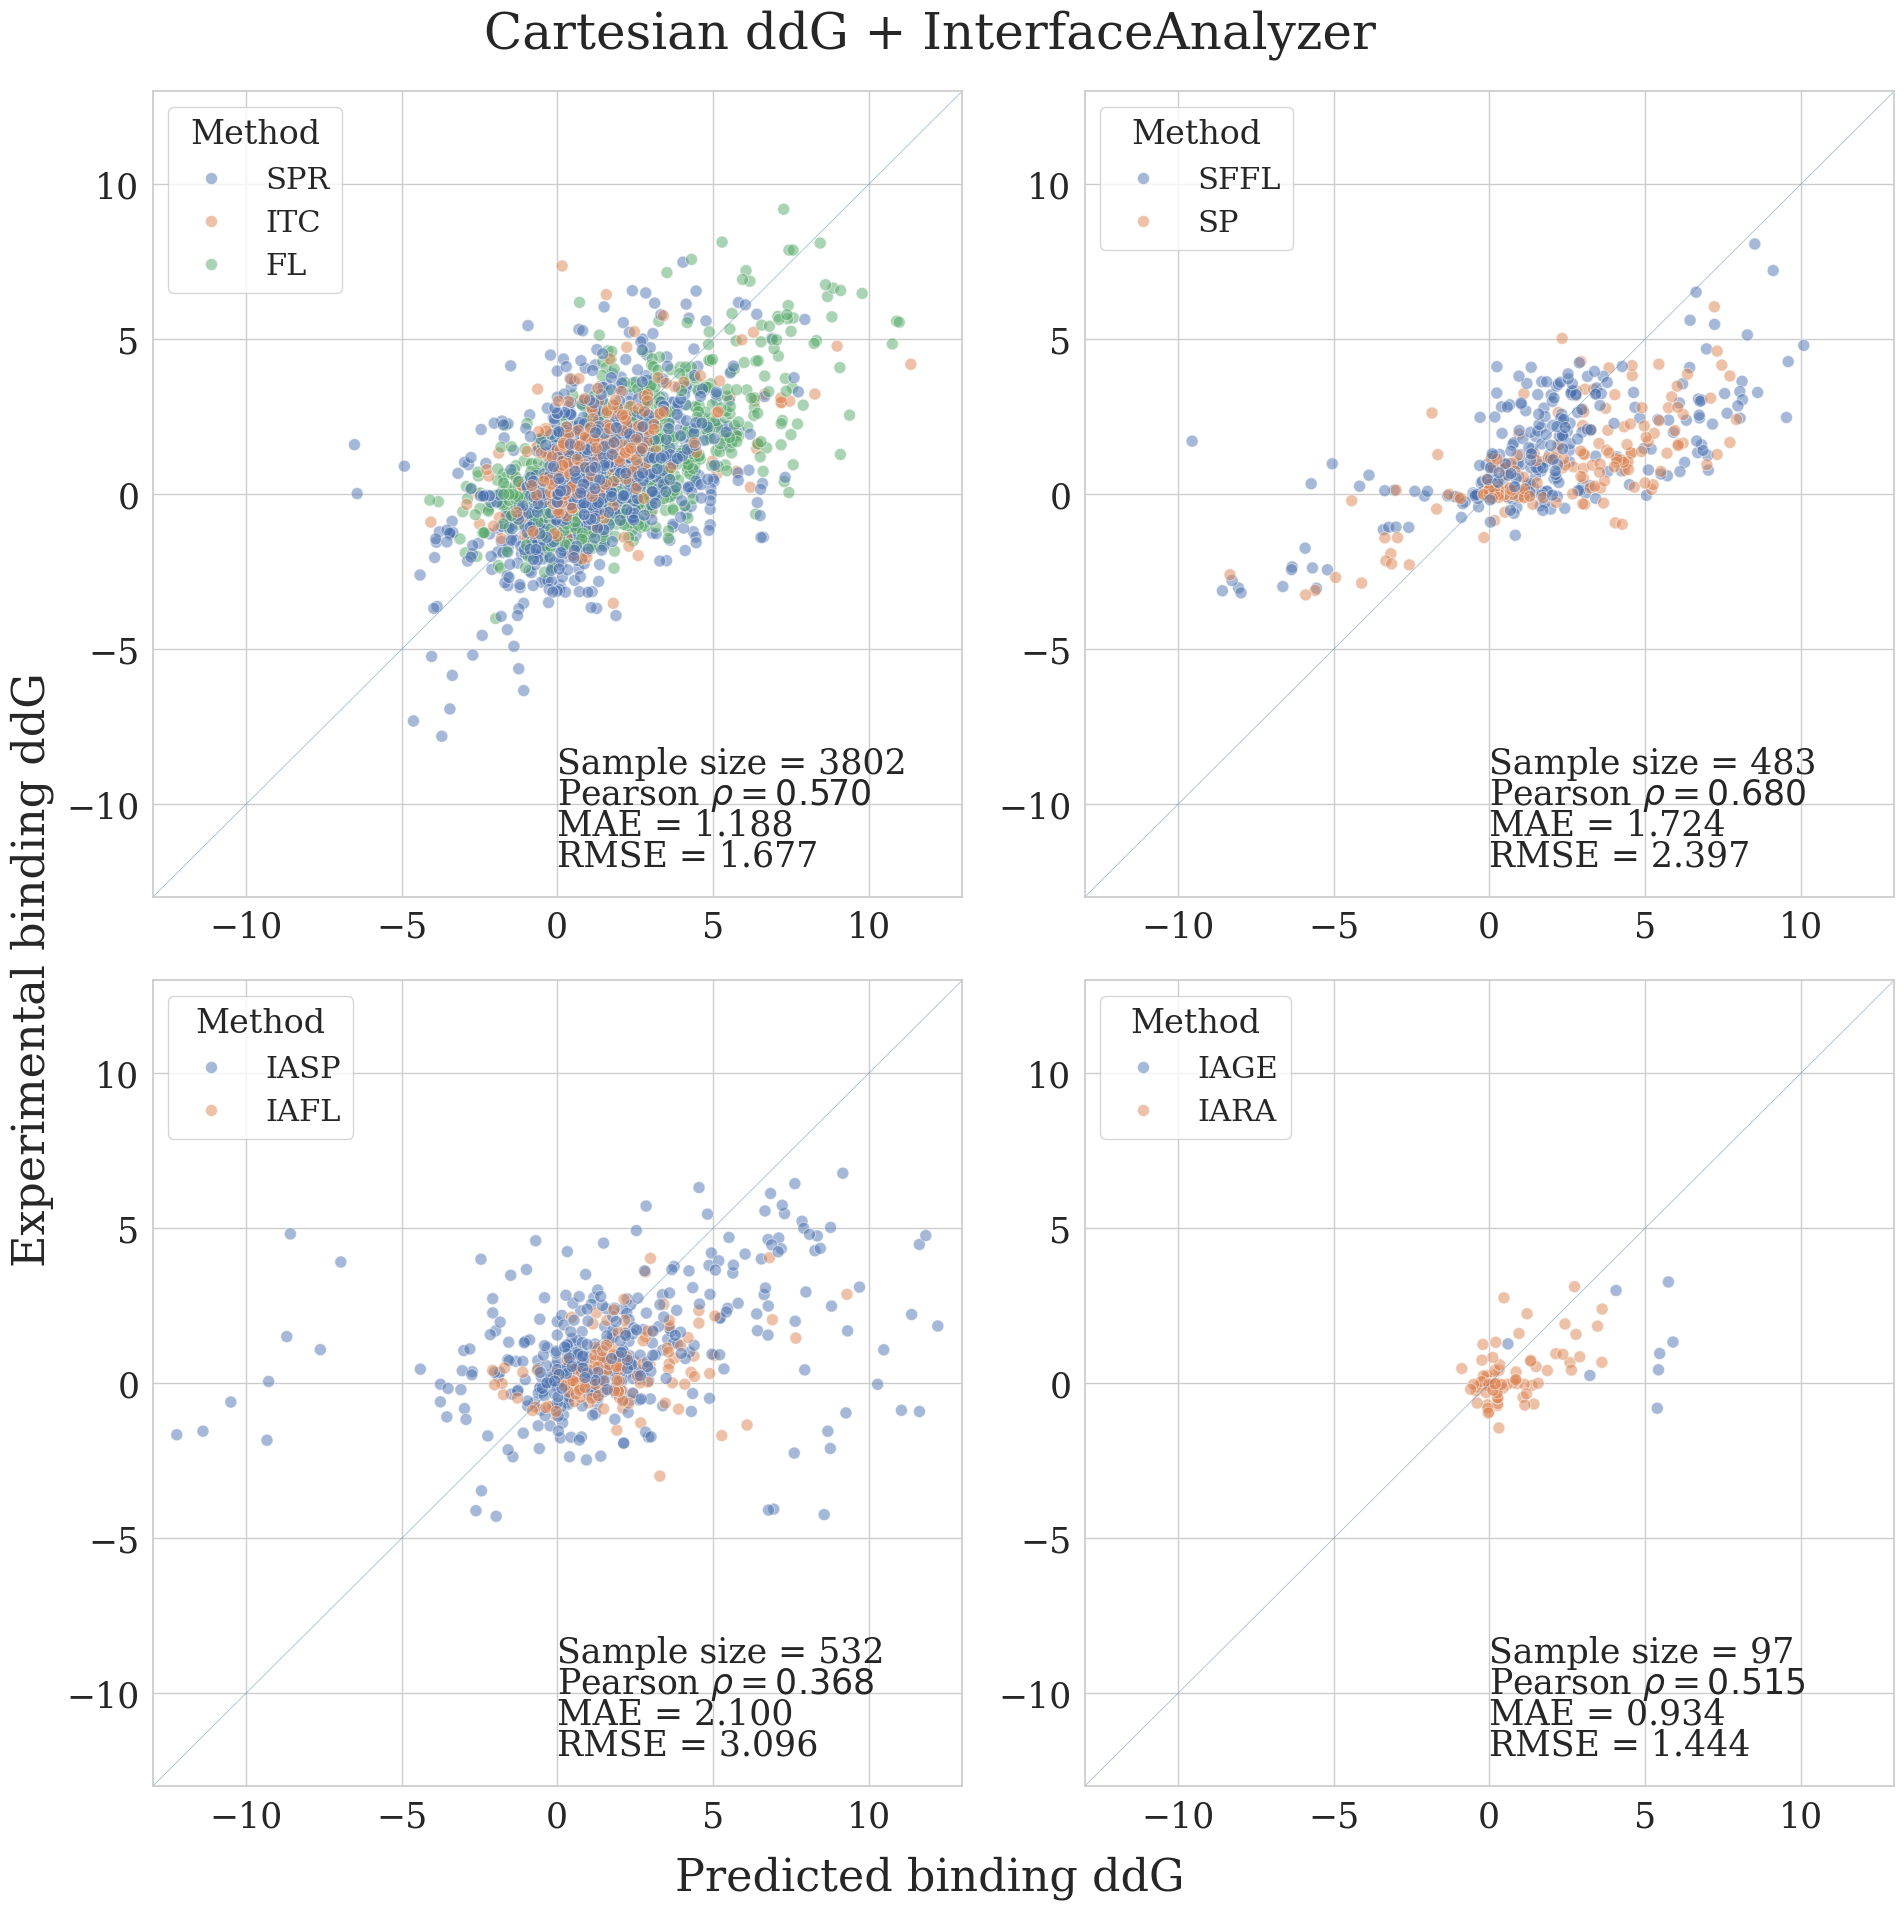

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
plt.setp(axes, xlim=(-13, 13), ylim=(-13, 13))
axes = axes.flatten()

for ax, l in zip(axes, list_of_lists):
    subset = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['Method'].isin(l)]
    sns.scatterplot(data=subset, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=75,
                       hue='Method',
                       ax=ax)
    # # Label the unfitting data points
    # x = subset['ddG_bind'].values
    # y = subset['mean_ddG_infc'].values
    # names = subset['variant'].values
    # # Distance to the diagonal both on x and y axis
    # #dist = abs(x-y)
    # txt_list=list()
    # for i in range(len(x)):
    #     # dist = np.sqrt((2*(abs(x-y))**2))/2
    #     dist = abs(x-y)
    #     sub_list = list()
    #     if (dist[i] > 4.5)&(len(names[i].split(':'))<=2):
    #         for point_mut in names[i].split(':'):
    #             sub_list.append(point_mut[-1])
    #         name = ','.join(sub_list)
            
    #         ax.text(x[i]+0.01, y[i]+0.01, names[i][-1], fontsize=13)
    #         #txt_list.append(plt.text(x[i]+0.01, y[i]+0.01, name, fontsize=10))
    # #adjust_text(txt_list)
    
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    ax.annotate(f'Sample size = {len(subset)}', xy=(0, -9), fontsize = 25)
    r, p = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(0, -10), fontsize = 25)
    error = mae(subset['ddG_bind'], subset['mean_ddG_infc'])
    ax.annotate(f'MAE = {error:.3f}', xy=(0, -11), fontsize = 25)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset['mean_ddG_infc']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(0, -12), fontsize = 25)
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_title(f'N of point mutations = {N}', fontsize = 28)
    sns.move_legend(ax, "upper left")
    
fig.text(0.5, 0.04, 'Predicted binding ddG', ha='center', fontsize=32)  # x label
fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=32)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=36)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.savefig('Figures/cart_ddG_IA_method_x4.pdf', format='pdf')

In [48]:
# skempi2_unfilt = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2/skempi_v2.csv', sep=';')
# skempi_unfilt_count = skempi2_unfilt[['#Pdb', 'Method']].groupby('Method').count().reset_index()
# skempi_unfilt_count.rename(columns={"#Pdb": "Percentage"}, inplace=True)
# skempi_unfilt_count['Percentage'] = skempi_unfilt_count['Percentage'] / len(skempi2_unfilt) * 100
# skempi_unfilt_count['Subset'] = 'All' 

In [65]:
#skempi2_unfilt = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2/skempi_v2.csv', sep=';')
skempi2_unfilt = exp_cart_ddG_all_no_nan.copy()
skempi_unfilt_count = skempi2_unfilt[['#Pdb', 'Method']].groupby('Method').count().reset_index()
skempi_unfilt_count.rename(columns={"#Pdb": "Percentage"}, inplace=True)
skempi_unfilt_count['Percentage'] = skempi_unfilt_count['Percentage'] / len(skempi2_unfilt) * 100
skempi_unfilt_count['Subset'] = 'All' 

In [66]:
outliers_meth = outliers.copy()
outliers_meth_count = outliers_meth[['#Pdb', 'Method']].groupby('Method').count().reset_index()
outliers_meth_count.rename(columns={"#Pdb": "Percentage"}, inplace=True)
outliers_meth_count['Percentage'] = outliers_meth_count['Percentage'] / len(outliers) * 100
outliers_meth_count['Subset'] = 'Outliers' 

In [67]:
#barplot_material = pd.concat([skempi_unfilt_count, skempi2_mm_count, skempi2_mm_err_count, outliers_meth_count])
barplot_material = pd.concat([skempi_unfilt_count, outliers_meth_count])

In [180]:
# Block of seaborn style settings
plt.rc('font', size=35) #controls default text size
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=35) #fontsize of the y tick labels

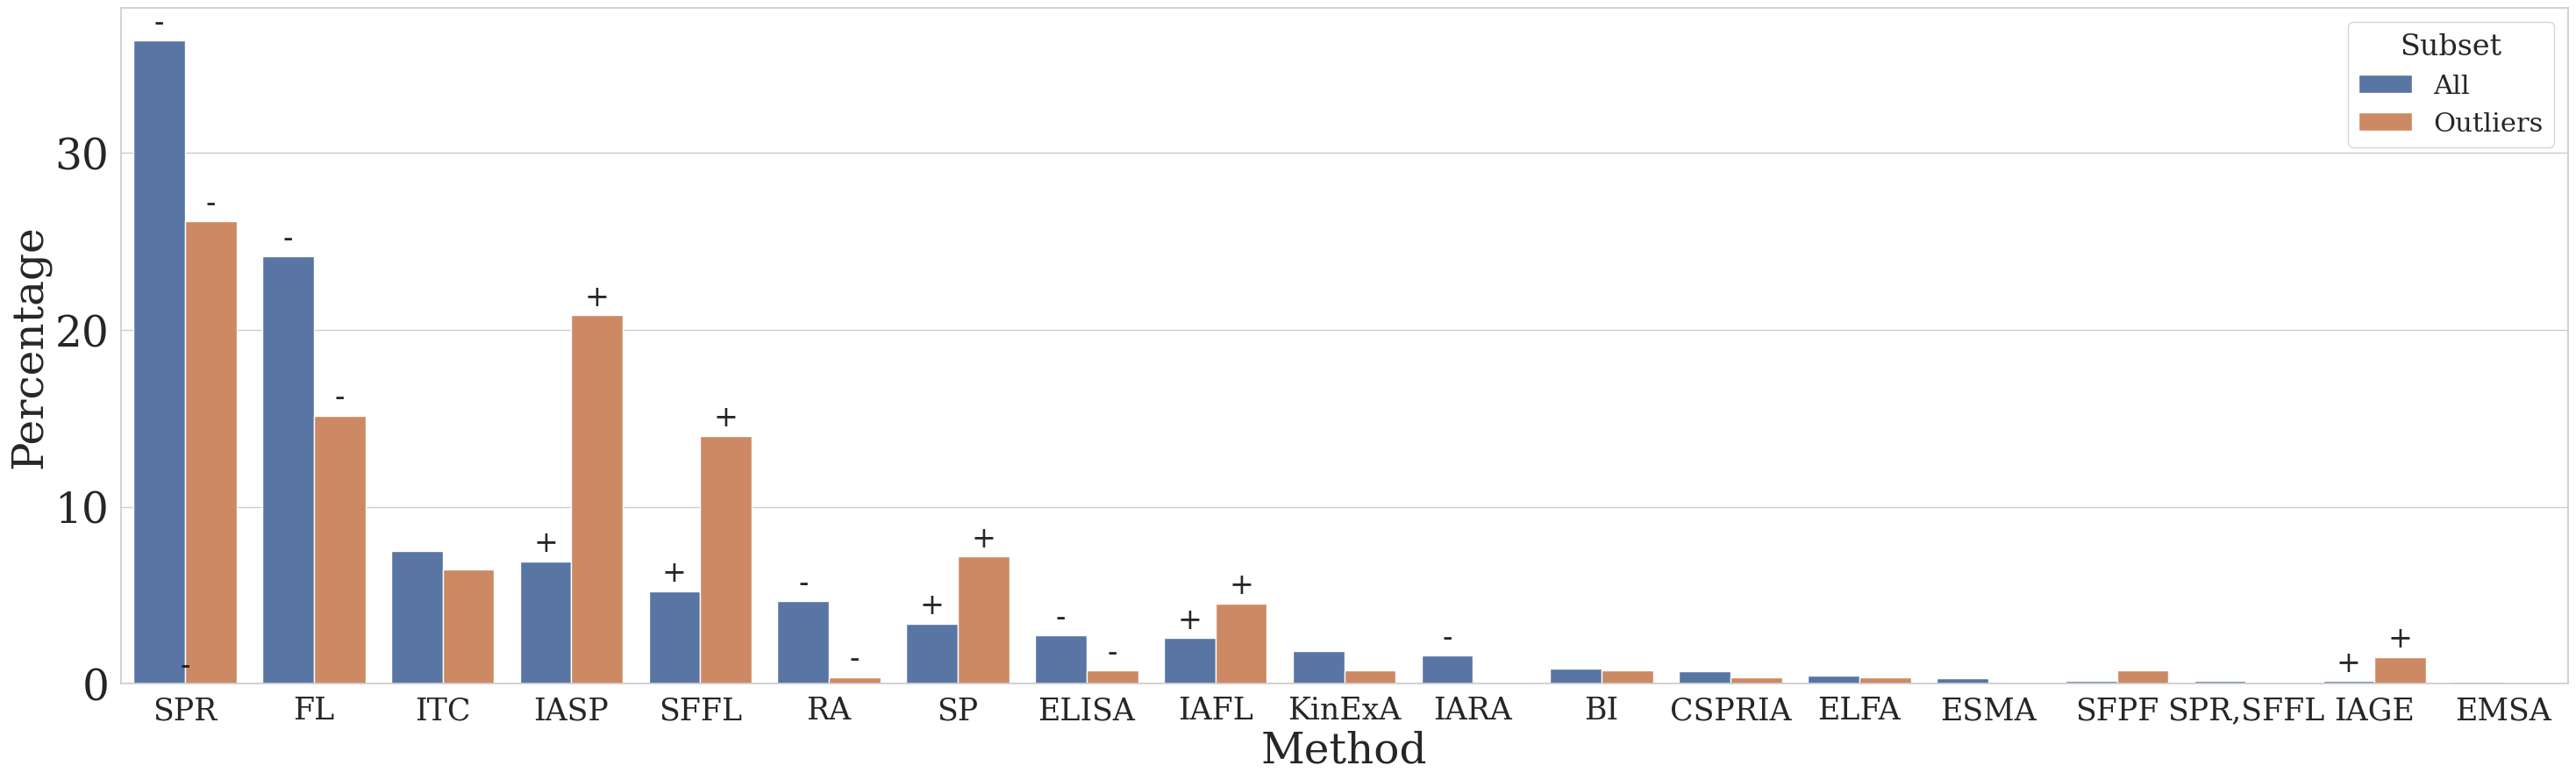

In [181]:
fig, ax = plt.subplots(figsize=(36, 10))
ax = sns.barplot(barplot_material, x="Method", y="Percentage", hue="Subset", order=skempi_unfilt_count.sort_values('Percentage', ascending=False)['Method'].values)

for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w/2, h + 1)
    
    tick_label = ax.get_xticklabels()[int(np.round(x+w/2))].get_text()
    text = ''
    if tick_label in list_under:
        text = '-'
    if tick_label in list_over:
        text = '+'
        
    ax.annotate(text=text, xy=xy, ha='center', va='center')

plt.xlabel('Method', fontsize=35)
plt.ylabel('Percentage', fontsize=35)
    
plt.savefig('Figures/methods_percentage.pdf', format='pdf')

In [132]:
import pandas as pd
import scipy.stats as stats
import io

df = exp_cart_ddG_all_no_nan.copy()
print("\n--- 2. Defining Groups ---")
df['Group'] = 'Non-Outlier'
df.loc[abs(df['ddG_bind']-df['mean_ddG_infc'])>4, 'Group'] = 'Outlier'

print(f"Total samples: {len(df)}")
print(f"Outlier samples: {len(df[df['Group'] == 'Outlier'])}")
print(f"Non-Outlier samples: {len(df[df['Group'] == 'Non-Outlier'])}")


# --- 2. Create the Contingency Table ---
# This table counts the occurrences of each 'Method' for each 'Group'.
print("\n--- 3. Building the Contingency Table ---")
contingency_table = pd.crosstab(df['Group'], df['Method'])

print("--- Original Contingency Table ---")
print(contingency_table)
print("\n" + "="*50 + "\n")


# --- 2. Loop Through Each Method to Create 2x2 Tables ---
print("--- Performing Post-Hoc Fisher's Exact Tests ---")
results = {}

# Get the list of all methods (columns)
all_methods = contingency_table.columns
list_over = list()
list_under = list()

for method in all_methods:
    # --- a. Create the 2x2 table ---
    
    # Select the current method's column
    current_method_col = contingency_table[method]
    
    # Select all other methods and sum them up row-wise
    other_methods_col = contingency_table.drop(columns=method).sum(axis=1)
    
    # Combine into a new 2x2 DataFrame
    post_hoc_table = pd.concat([current_method_col, other_methods_col], axis=1)
    post_hoc_table.columns = [method, 'All Others']
    
    print(f"--- Testing Method: {method} ---")
    print(post_hoc_table)
    
    # --- b. Run Fisher's Exact Test on the 2x2 table ---
    odds_ratio, p_value = stats.fisher_exact(post_hoc_table)
    
    print(f"P-value: {p_value:.4f}")
    
    # Store the result
    results[method] = p_value
    
    # Check for significance (using a common alpha level)
    if p_value < 0.05:
        print("Result: SIGNIFICANT. This method's proportion is different in the outlier group.")
        all_freq = post_hoc_table['All Others']['Outlier']/(post_hoc_table['All Others'].sum())
        meth_freq = post_hoc_table[method]['Outlier']/(post_hoc_table[method].sum())
        print(f"All other method outlier frequency: {all_freq}")
        print(f"{method} outlier frequency: {meth_freq}")
        if meth_freq>all_freq:
            list_over.append(method)
        else:
            list_under.append(method)
    print("-" * 30)

# --- 3. Display Final Summary ---
print("\n" + "="*50)
print("--- Summary of P-values for Each Method ---")
print("="*50)

# Create a DataFrame for a nice, sorted view
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['p_value'])
results_df['is_significant'] = results_df['p_value'] < 0.05
results_df = results_df.sort_values(by='p_value')

print(results_df)

print("\nConclusion:")
print(f"Methods {list_over}' are disproportionately overrepresented in your outlier group.")
print(f"Methods {list_under}' are disproportionately underrepresented in your outlier group.")




--- 2. Defining Groups ---
Total samples: 5587
Outlier samples: 264
Non-Outlier samples: 5323

--- 3. Building the Contingency Table ---
--- Original Contingency Table ---
Method       BI  CSPRIA  ELFA  ELISA  EMSA  ESMA    FL  IAFL  IAGE  IARA  \
Group                                                                      
Non-Outlier  47      39    24    150     6    17  1310   133     4    89   
Outlier       2       1     1      2     0     0    40    12     4     0   

Method       IASP  ITC  KinExA   RA  SFFL  SFPF   SP   SPR  SPR,SFFL  
Group                                                                 
Non-Outlier   332  403     101  260   256     8  171  1963        10  
Outlier        55   17       2    1    37     2   19    69         0  


--- Performing Post-Hoc Fisher's Exact Tests ---
--- Testing Method: BI ---
             BI  All Others
Group                      
Non-Outlier  47        5276
Outlier       2         262
P-value: 1.0000
------------------------------
-

In [109]:
print(list_over)
print(list_under)

['IAFL', 'IAGE', 'IASP', 'SFFL', 'SP']
['ELISA', 'FL', 'IARA', 'RA', 'SPR']


Text(5, -12, 'single mut $\\rho = 0.420$')

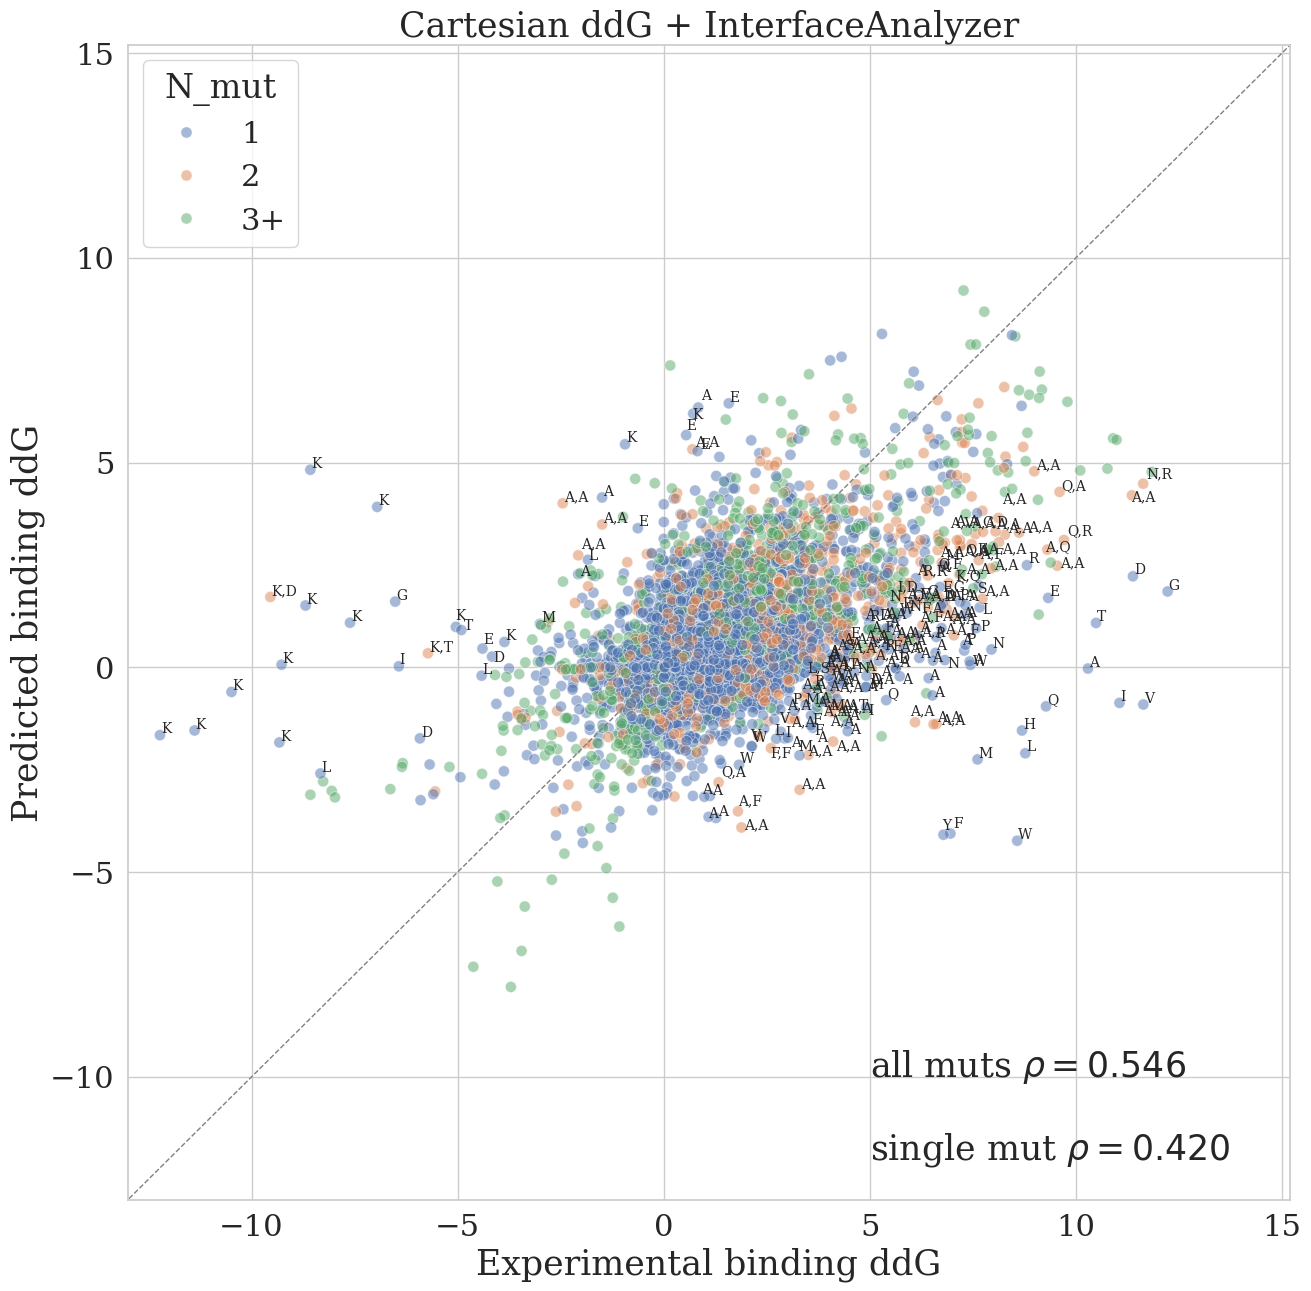

In [52]:
fig, axes = plt.subplots(1,1, figsize = (15,15))
plt.setp(axes, xlim=(-13, 15.2), ylim=(-13, 15.2))
# Create the scatter plot

plot = sns.scatterplot(data=exp_cart_ddG_all_no_nan, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=65, hue='N_mut')

plt.xlabel('Experimental binding ddG', fontsize=25)
plt.ylabel('Predicted binding ddG', fontsize=25)
plt.title('Cartesian ddG + InterfaceAnalyzer', fontsize=25)

# Label the unfitting data points
x = exp_cart_ddG_all_no_nan['ddG_bind'].values
y = exp_cart_ddG_all_no_nan['mean_ddG_infc'].values
names = exp_cart_ddG_all_no_nan['variant'].values
# Distance to the diagonal both on x and y axis
#dist = abs(x-y)
txt_list=list()
for i in range(len(x)):
    # dist = np.sqrt((2*(abs(x-y))**2))/2
    dist = abs(x-y)
    sub_list = list()
    if (dist[i] > 4)&(len(names[i].split(':'))<=2):
        for point_mut in names[i].split(':'):
            sub_list.append(point_mut[-1])
        name = ','.join(sub_list)
        
        #plot.text(x[i]+0.01, y[i]+0.01, names[i][-1], fontsize=13)
        txt_list.append(plot.text(x[i]+0.01, y[i]+0.01, name, fontsize=10))
            
adjust_text(txt_list)

min_val = -15 - 1.5
max_val = 15 + 1.5
axes.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(exp_cart_ddG_all_no_nan['ddG_bind'],
                      exp_cart_ddG_all_no_nan['mean_ddG_infc'])
axes.annotate(f'all muts $\\rho = {r:.3f}$', xy=(5, -10), fontsize = 25)

r, p = stats.pearsonr(exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']=='1']['ddG_bind'],
                      exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']=='1']['mean_ddG_infc'])
axes.annotate(f'single mut $\\rho = {r:.3f}$', xy=(5, -12), fontsize = 25)

#plt.savefig('Figures/cart_ddG_IA.pdf', format='pdf')

## Bits and pieces

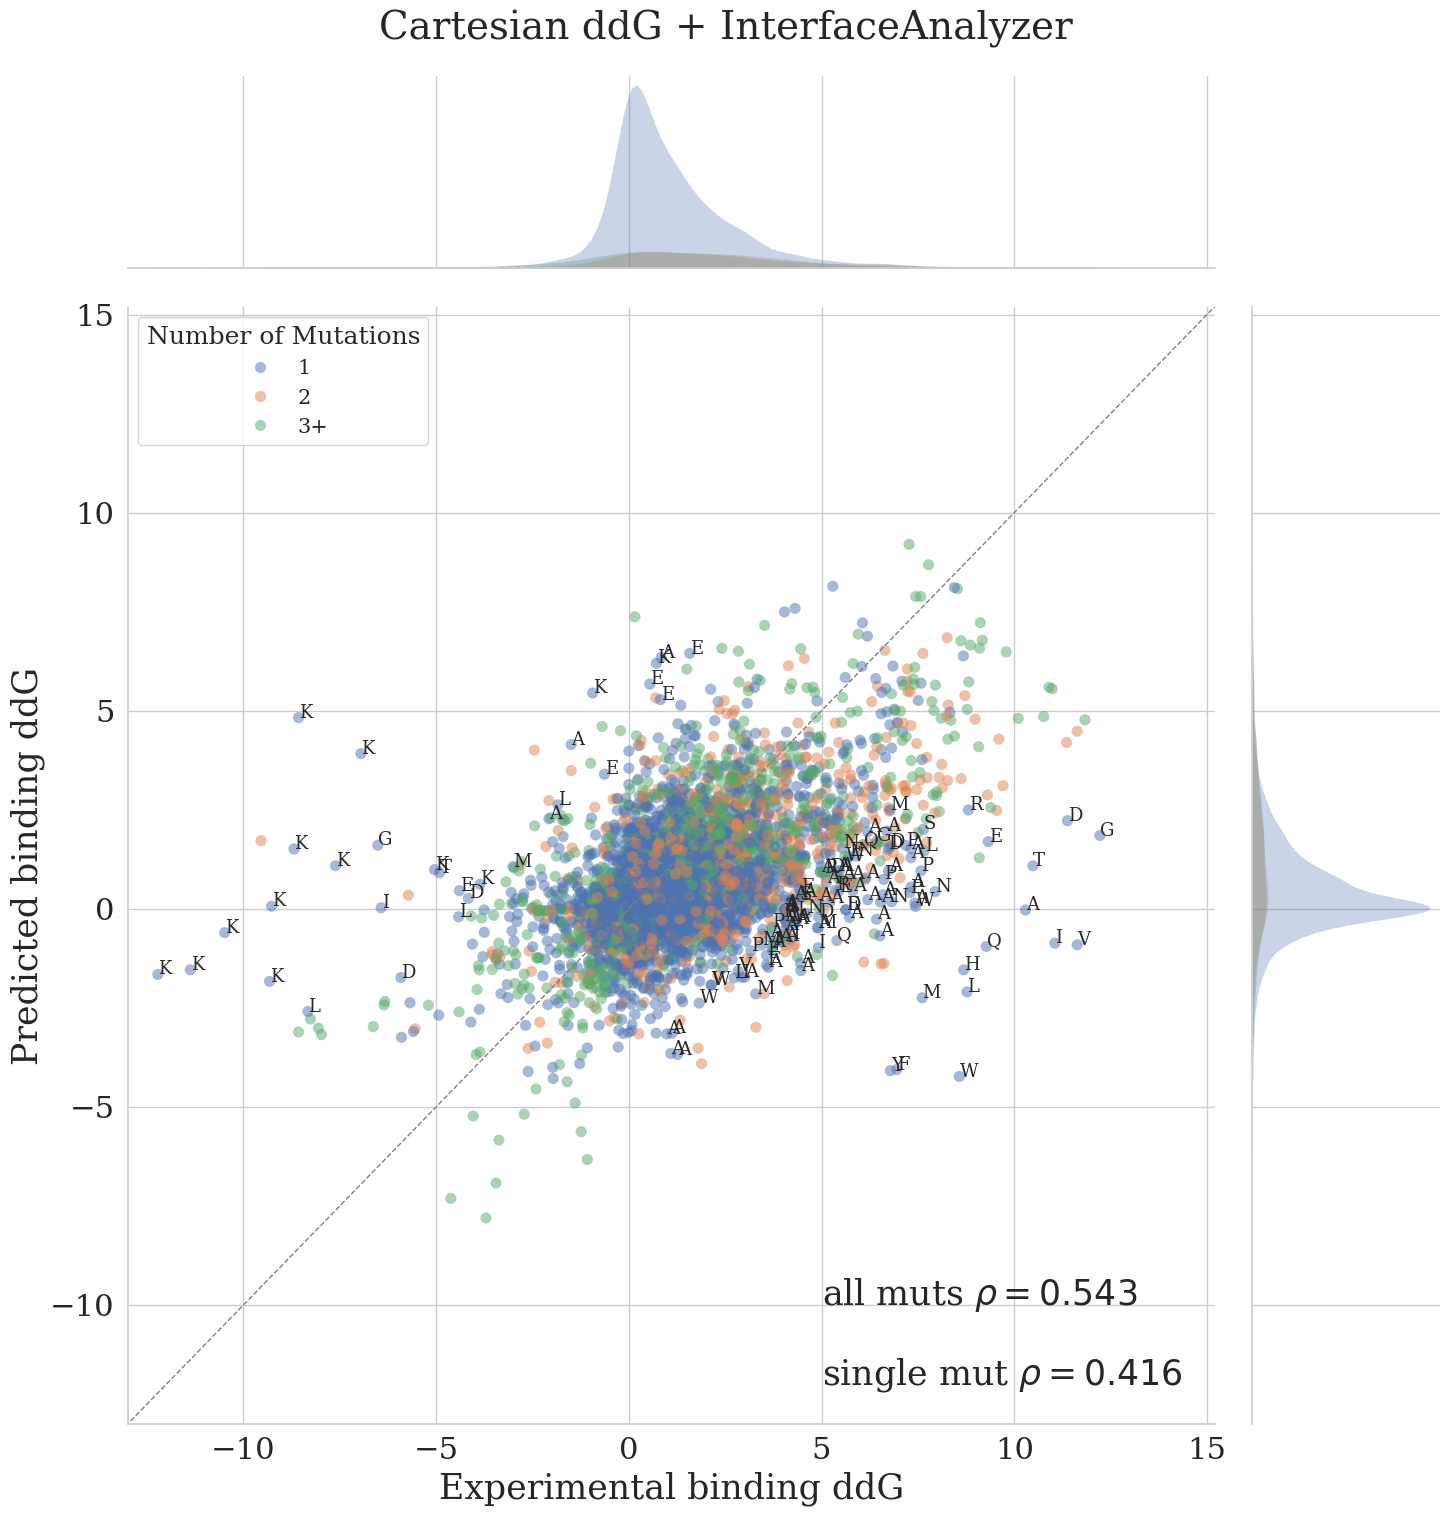

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set up the JointGrid
g = sns.JointGrid(data=exp_cart_ddG_all_no_nan, x='ddG_bind', y='mean_ddG_infc',
                  height=15,  # Adjust overall figure size
                  xlim=(-13, 15.2), ylim=(-13, 15.2), hue="N_mut")

#g = g.plot(sns.scatterplot, sns.kdeplot, alpha=0.5, linewidth=0, size=65)
g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=0, s=65)
g.plot_marginals(sns.kdeplot, fill=True, alpha=0.3, linewidth=0)

# # Plot the scatter plot on the main axes
# # We iterate through the unique hue categories to plot each subgroup separately
# # This allows seaborn to assign distinct colors for the marginal KDEs as well.
# for mut_type in exp_cart_ddG_all_no_nan['N_mut'].unique():
#     subset = exp_cart_ddG_all_no_nan[exp_cart_ddG_all_no_nan['N_mut'] == mut_type]
#     g.plot_joint(sns.scatterplot, alpha=0.5, s=65, label=f'N_mut={mut_type}') # Label for legend
#     # Plot marginal KDEs for each hue subgroup
#     g.plot_marginals(sns.kdeplot, fill=True, alpha=0.3, linewidth=0) # linewidth=0 hides the line itself


# Add labels and title
g.set_axis_labels(xlabel='Experimental binding ddG', ylabel='Predicted binding ddG', fontsize=25)
g.fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=28, y=1.02) # Adjust suptitle position


# Add the diagonal line
min_val = -15 - 1.5
max_val = 15 + 1.5
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

# Label the unfitting data points
x = exp_cart_ddG_all_no_nan['ddG_bind'].values
y = exp_cart_ddG_all_no_nan['mean_ddG_infc'].values
names = exp_cart_ddG_all_no_nan['variant'].values
txt_list = list()
for i in range(len(x)):
    dist = abs(x-y)
    if (dist[i] > 4) and (len(names[i].split(':'))==1):
        g.ax_joint.text(x[i]+0.01, y[i]+0.01, names[i][-1], fontsize=13)
#         txt_list.append(g.ax_joint.text(x[i]+0.01, y[i]+0.01, names[i][-1], fontsize=13))
        
# adjust_text(txt_list)

# Calculate and annotate Pearson correlation coefficients
r_all, p_all = stats.pearsonr(exp_cart_ddG_all_no_nan['ddG_bind'],
                              exp_cart_ddG_all_no_nan['mean_ddG_infc'])
g.ax_joint.annotate(f'all muts $\\rho = {r_all:.3f}$', xy=(5, -10), fontsize = 25)

single_mut_data = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']=='1']
r_single, p_single = stats.pearsonr(single_mut_data['ddG_bind'],
                                    single_mut_data['mean_ddG_infc'])
g.ax_joint.annotate(f'single mut $\\rho = {r_single:.3f}$', xy=(5, -12), fontsize = 25)

# Add a legend to distinguish hue subgroups
g.ax_joint.legend(title='Number of Mutations', fontsize=15, title_fontsize=18)

# Adjust layout and save the figure
#plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust rect to prevent suptitle overlap
plt.savefig('Figures/cart_ddG_IA_sing_marg_dens.pdf', format='pdf')

In [ ]:
plt.rc('font', size=23) #controls default text size
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

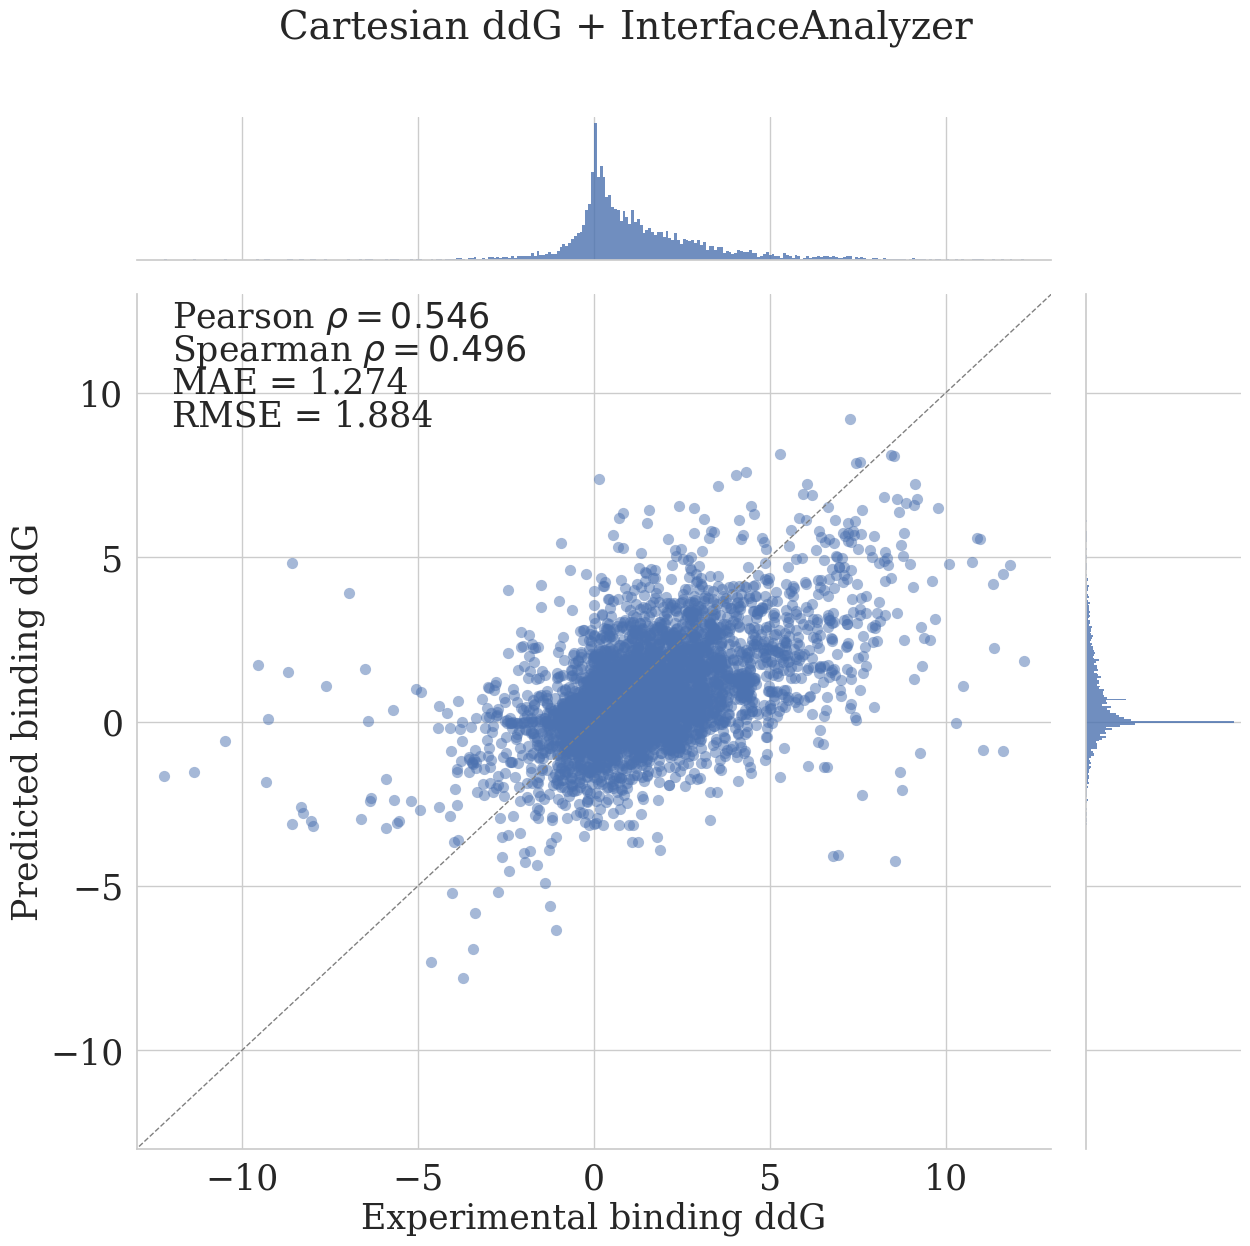

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set up the JointGrid
g = sns.JointGrid(data=exp_cart_ddG_all_no_nan, x='ddG_bind', y='mean_ddG_infc',
                  height=13,  # Adjust overall figure size
                  xlim=(-13, 13), ylim=(-13, 13))

#g = g.plot(sns.scatterplot, sns.kdeplot, alpha=0.5, linewidth=0, size=65)
g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=0, s=65)
# g.plot_marginals(sns.kdeplot, fill=True, alpha=0.6, linewidth=0)
g.plot_marginals(sns.histplot, fill=True, alpha=0.8, linewidth=0, bins=300)

# # Plot the scatter plot on the main axes
# # We iterate through the unique hue categories to plot each subgroup separately
# # This allows seaborn to assign distinct colors for the marginal KDEs as well.
# for mut_type in exp_cart_ddG_all_no_nan['N_mut'].unique():
#     subset = exp_cart_ddG_all_no_nan[exp_cart_ddG_all_no_nan['N_mut'] == mut_type]
#     g.plot_joint(sns.scatterplot, alpha=0.5, s=65, label=f'N_mut={mut_type}') # Label for legend
#     # Plot marginal KDEs for each hue subgroup
#     g.plot_marginals(sns.kdeplot, fill=True, alpha=0.3, linewidth=0) # linewidth=0 hides the line itself


# Add labels and title
g.set_axis_labels(xlabel='Experimental binding ddG', ylabel='Predicted binding ddG', fontsize=25)
g.fig.suptitle('X5723', fontsize=28, y=1) # Adjust suptitle position


# Add the diagonal line
min_val = -15 - 1.5
max_val = 15 + 1.5
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

# Calculate and annotate Pearson correlation coefficients
r_p, p_p = stats.pearsonr(exp_cart_ddG_all_no_nan['ddG_bind'],
                              exp_cart_ddG_all_no_nan['mean_ddG_infc'])
g.ax_joint.annotate(f"Pearson $\\rho = {r_p:.3f}$", xy=(-12, 12), fontsize = 25)

r_s, p_s = stats.spearmanr(exp_cart_ddG_all_no_nan['ddG_bind'],
                                     exp_cart_ddG_all_no_nan['mean_ddG_infc'])
g.ax_joint.annotate(f'Spearman $\\rho = {r_s:.3f}$', xy=(-12, 11), fontsize = 25)

error = mae(exp_cart_ddG_all_no_nan['ddG_bind'], exp_cart_ddG_all_no_nan['mean_ddG_infc'])
g.ax_joint.annotate(f'MAE = {error:.3f}', xy=(-12, 10), fontsize = 25)

rmse = sqrt(mean_squared_error(exp_cart_ddG_all_no_nan['ddG_bind'], exp_cart_ddG_all_no_nan['mean_ddG_infc']))
g.ax_joint.annotate(f'RMSE = {rmse:.3f}', xy=(-12, 9), fontsize = 25)

# # Add a legend to distinguish hue subgroups
# g.ax_joint.legend(title='Number of Mutations', fontsize=15, title_fontsize=18)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust rect to prevent suptitle overlap
plt.savefig('Figures/cart_ddG_IA_marg_dens_no_tags.pdf', format='pdf')

In [100]:
S2536_sub[S2536_sub['ddG_bind'].isna()]

Entry   PDB Interacting Chains Mutation(s)  \
99           114,188  1BRS                A:D       DD39A   
262          439,451  2WPT                A:B       SB67A   
481         845,1262  1JTG                A:B       EA79K   
496         947,5776  1JTG                A:B       EA85A   
825        2080,3057  1DAN              HL:TU      VU113A   
1034       2434,3242  1CHO              EFG:I       TI14E   
1772       3625,3634  1BD2             ABC:DE        YC5A   
2052       4728,4740  4I77               HL:Z      YH101A   
2059       4735,4747  4I77               HL:Z       YL32A   
2102  5327,5364,5441  3S9D                A:B       RA26A   
2357            6667  1C1Y                A:B       DA38A   
2358            6669  1LFD                A:B       YB32W   

     Mutation(s)_in_raw_pdb  Temperature  \
99                    DD39A       298.00   
262                   SB74A       298.00   
481                  EA104K       298.00   
496                  EA110A       297.00   
825                  VU207A       298.00   
1034                  TI17E       294.00   
1772                   YC5A       298.00   
2052                  YH98A       304.00   
2059                  YL28A       304.00   
2102                  RA33A       298.00   
2357                  DA38A       298.15   
2358                 YB232W       298.15   

                                              Reference   DDGb DDGb_SK1  \
99    7739054,Water-mediated_interaction_at_a_protei...  6.790     6.79   
262                                            18471830 -0.134   -0.134   
481                                    9891008,21294157  3.239    4.233   
496                                   17070843,24947275  1.378     4.06   
825                                     7947809,7654692  0.690     0.69   
1034  11171964,Stephen_Ming-teh_Lu_PhD_Thesis_Purdue...  5.582    5.582   
1772                                           23736024  3.340      XXX   
2052                                           23357170  1.654      XXX   
2059                                           23357170  0.815      XXX   
2102                         10556041,10984492,21854986  5.123      XXX   
2357                                            8636102  2.620      XXX   
2358                                            8636102 -0.211      XXX   

        cRSA  ...  small-to-large  type_of_change_infc  type_of_change_aa  \
99     0.968  ...             NaN                  NaN                NaN   
262    4.186  ...             NaN                  NaN                NaN   
481    6.048  ...             NaN                  NaN                NaN   
496    7.146  ...             NaN                  NaN                NaN   
825    2.422  ...             NaN                  NaN                NaN   
1034  16.190  ...             NaN                  NaN                NaN   
1772   1.514  ...             NaN                  NaN                NaN   
2052   8.374  ...             NaN                  NaN                NaN   
2059  35.450  ...             NaN                  NaN                NaN   
2102  10.682  ...             NaN                  NaN                NaN   
2357  11.212  ...             NaN                  NaN                NaN   
2358  89.958  ...             NaN                  NaN                NaN   

     N_mut multiple_measurements no_proper_value  Method  LChains  RChains  \
99     NaN                   NaN             NaN     NaN      NaN      NaN   
262    NaN                   NaN             NaN     NaN      NaN      NaN   
481    NaN                   NaN             NaN     NaN      NaN      NaN   
496    NaN                   NaN             NaN     NaN      NaN      NaN   
825    NaN                   NaN             NaN     NaN      NaN      NaN   
1034   NaN                   NaN             NaN     NaN      NaN      NaN   
1772     1                 False  no binding MUT     SPR      NaN      NaN   
2052   NaN                   NaN             N

In [114]:
skempi2_raw.loc[(skempi2_raw['#Pdb'].str[0:4]=='1BRS')&(skempi2_raw['Mutation(s)_PDB']=='DD39A')].values

array([['1BRS_A_D', 'DD39A', 'DD39A', 'COR', nan,
        '1BRS_A_D,1B2U_A_D,1B2S_A_D,1B3S_A_D,1X1W_A_D,1X1X_A_D',
        '4.06E-09', 4.06e-09, '1E-14', 1e-14, '7739054', 'Barnase',
        'Barstar', '298', 190000000.0, 190000000.0, 370000000.0,
        370000000.0, '9E-01', 0.9, '3.73E-06', 3.73e-06, -7.4, -19.3,
        13.1, -1.01,
        'Thermodynamic data from 9126847. ITC dG(mut) is -11.1 kcal/mol,,',
        'ITC', 1],
       ['1BRS_A_D', 'DD39A', 'DD39A', 'COR', nan,
        '1BRS_A_D,1B2U_A_D,1B2S_A_D,1B3S_A_D,1X1W_A_D,1X1X_A_D',
        '2.96E-06', 2.96e-06, '1.32E-10', 1.32e-10,
        'Water-mediated interaction at a protein-protein interface, Chemical Physics, Volume 307, Issues 2-3, 2004',
        'Barnase', 'Barstar', '298', 155000.0, 155000.0, 874000.0,
        874000.0, '4.57E-01', 0.457, '1.15E-04', 0.000115, nan, nan, nan,
        nan, nan, 'SPR', 1]], dtype=object)

In [115]:
skempi2_raw.loc[(skempi2_raw['#Pdb'].str[0:4]=='1BRS')&(skempi2_raw['Mutation(s)_PDB']=='DD39A')].columns

Index(['#Pdb', 'Mutation(s)_PDB', 'Mutation(s)_cleaned',
       'iMutation_Location(s)', 'Hold_out_type', 'Hold_out_proteins',
       'Affinity_mut (M)', 'Affinity_mut_parsed', 'Affinity_wt (M)',
       'Affinity_wt_parsed', 'Reference', 'Protein 1', 'Protein 2',
       'Temperature', 'kon_mut (M^(-1)s^(-1))', 'kon_mut_parsed',
       'kon_wt (M^(-1)s^(-1))', 'kon_wt_parsed', 'koff_mut (s^(-1))',
       'koff_mut_parsed', 'koff_wt (s^(-1))', 'koff_wt_parsed',
       'dH_mut (kcal mol^(-1))', 'dH_wt (kcal mol^(-1))',
       'dS_mut (cal mol^(-1) K^(-1))', 'dS_wt (cal mol^(-1) K^(-1))', 'Notes',
       'Method', 'SKEMPI version'],
      dtype='object')

In [105]:
S2536_sub.dropna(subset=['DDGb'])

Entry   PDB Interacting Chains Mutation(s)  \
0                  1  1CSE                E:I       LI38G   
1                  2  1CSE                E:I       LI38S   
2                  3  1CSE                E:I       LI38P   
3                  4  1CSE                E:I       LI38I   
4                  5  1CSE                E:I       LI38D   
...              ...   ...                ...         ...   
2532            6933  4L0P                A:B       EA27K   
2533            6934  4L0P                A:B       NA59S   
2534            6935  4L0P                A:B       TA76Q   
2535            6936  4L0P                A:B      TA140N   
2536  7044,7045,7046  1YQV               HL:Y       RY45K   

     Mutation(s)_in_raw_pdb  Temperature Reference   DDGb DDGb_SK1    cRSA  \
0                     LI45G        294.0   9048543  2.249    2.249   8.359   
1                     LI45S        294.0   9048543  1.172    1.172   8.359   
2                     LI45P        294.0   9048543  6.672    6.672   8.359   
3                     LI45I        294.0   9048543  2.941    2.941   8.359   
4                     LI45D        294.0   9048543  4.351    4.351   8.359   
...                     ...          ...       ...    ...      ...     ...   
2532                  EA53K        298.0  22242939  2.665      XXX   8.045   
2533                  NA85S        298.0  22242939  0.314      XXX  21.901   
2534                 TA102Q        298.0  22242939  1.472      XXX   0.000   
2535                 TA166N        298.0  22242939  0.278      XXX  42.111   
2536                  RY45K        297.0   9252107  1.867      XXX   3.279   

      ...  small-to-large   type_of_change_infc        type_of_change_aa  \
0     ...           False      infc to non-infc   hydrophobic to special   
1     ...           False      infc to non-infc     hydrophobic to polar   
2     ...           False      infc to non-infc   hydrophobic to special   
3     ...           False          infc to infc                same type   
4     ...           False      infc to non-infc  hydrophobic to negative   
...   ...             ...                   ...                      ...   
2532  ...            True  non-infc to non-infc     negative to positive   
2533  ...           False  non-infc to non-infc                same type   
2534  ...            True  non-infc to non-infc                same type   
2535  ...            True  non-infc to non-infc                same type   
2536  ...           False      infc to non-infc                same type   

     N_mut multiple_measurements no_proper_value  Method  LChains  RChains  \
0        1                 False         Regular    IASP        E        I   
1        1                 False         Regular    IASP        E        I   
2        1                 False         Regular    IASP        E        I   
3        1                 False         Regular    IASP        E        I   
4        1                 False         Regular    IASP        E        I   
...    ...                   ...             ...     ...      ...      ...   
2532     1                 False         Regular   ELISA        A        B   
2533     1                 False         Regular   ELISA        A        B   
2534     1                 False         Regular   ELISA        A        B   
2535     1                 False         Regular   ELISA        A        B   
2536     1                  True         Regular     ITC       HL        Y   

      Chains  
0         EI  
1         EI  
2         EI  
3         EI  
4         EI  
...      ...  
2532      AB  
2533      AB  
2534      AB  
2535      AB  
2536     HLY  

[2537 rows x 56 columns]

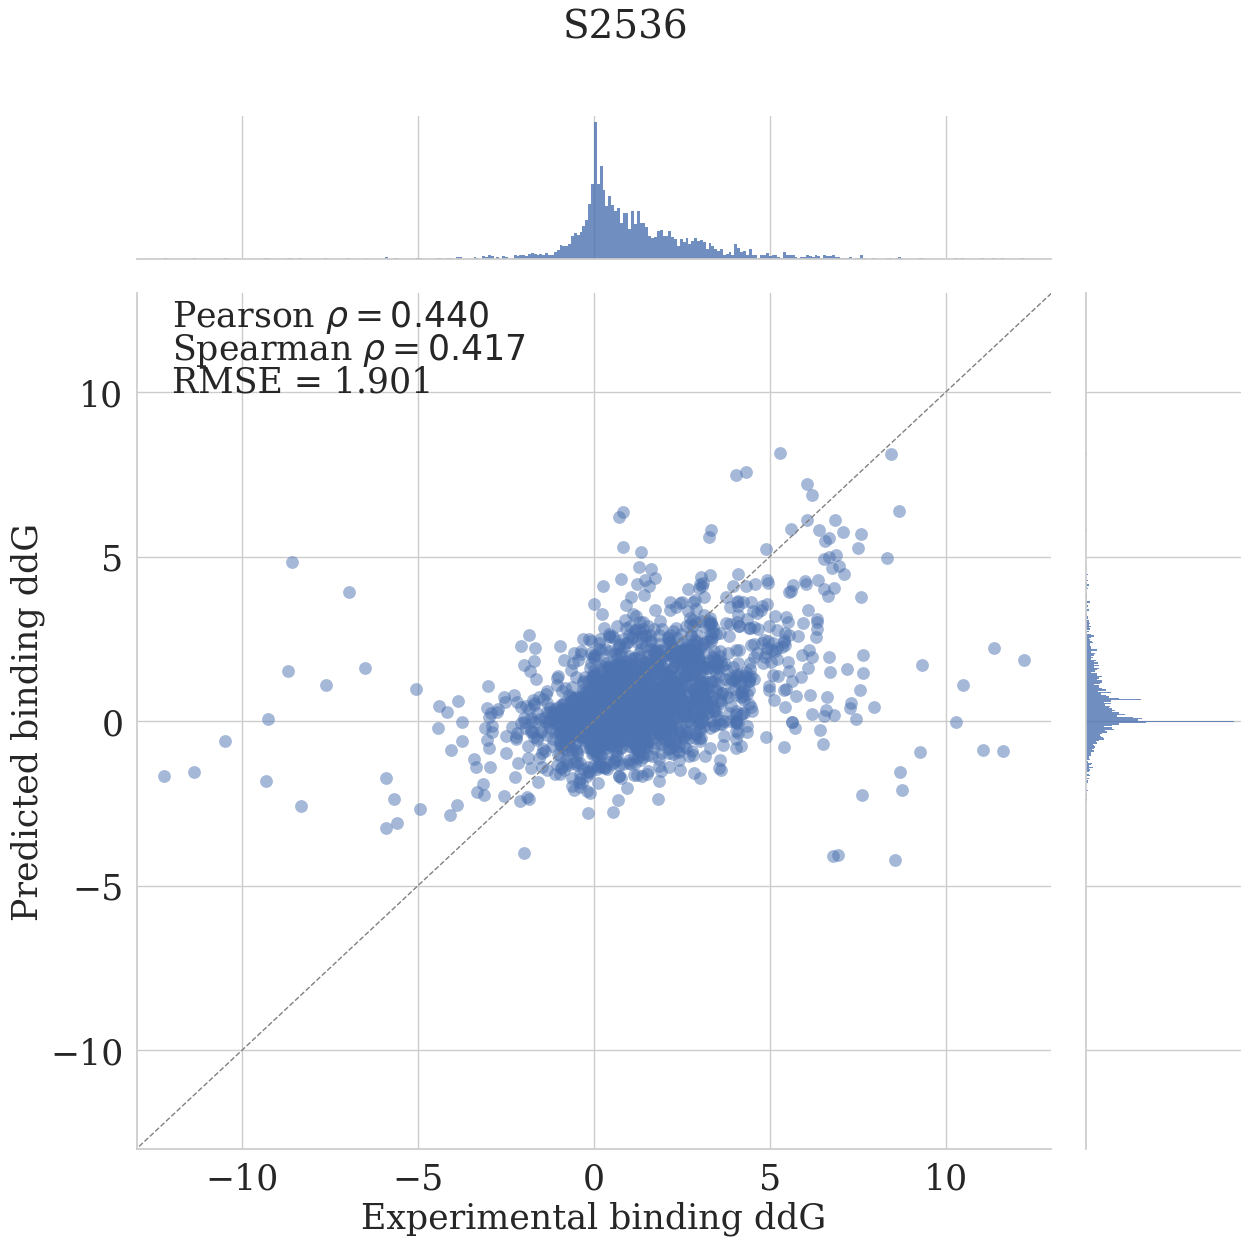

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df = S2536_sub.dropna(subset=['mean_ddG_infc'])

# Set up the JointGrid
g = sns.JointGrid(data=df, x='DDGb', y='mean_ddG_infc',
                  height=13,  # Adjust overall figure size
                  xlim=(-13, 13), ylim=(-13, 13))

#g = g.plot(sns.scatterplot, sns.kdeplot, alpha=0.5, linewidth=0, size=65)
g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=0, s=85)
# g.plot_marginals(sns.kdeplot, fill=True, alpha=0.6, linewidth=0)
g.plot_marginals(sns.histplot, fill=True, alpha=0.8, linewidth=0, bins=300)

# Add labels and title
g.set_axis_labels(xlabel='Experimental binding ddG', ylabel='Predicted binding ddG', fontsize=25)
g.fig.suptitle('S2536', fontsize=28, y=1) # Adjust suptitle position


# Add the diagonal line
min_val = -15 - 1.5
max_val = 15 + 1.5
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

# Calculate and annotate Pearson correlation coefficients
r_p, p_p = stats.pearsonr(df['DDGb'], df['mean_ddG_infc'])
g.ax_joint.annotate(f"Pearson $\\rho = {r_p:.3f}$", xy=(-12, 12), fontsize = 25)

r_s, p_s = stats.spearmanr(df['DDGb'], df['mean_ddG_infc'])
g.ax_joint.annotate(f'Spearman $\\rho = {r_s:.3f}$', xy=(-12, 11), fontsize = 25)

rmse = sqrt(mean_squared_error(df['DDGb'], df['mean_ddG_infc']))
g.ax_joint.annotate(f'RMSE = {rmse:.3f}', xy=(-12, 10), fontsize = 25)

# # Add a legend to distinguish hue subgroups
# g.ax_joint.legend(title='Number of Mutations', fontsize=15, title_fontsize=18)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust rect to prevent suptitle overlap
plt.savefig('Figures/S2536.pdf', format='pdf')

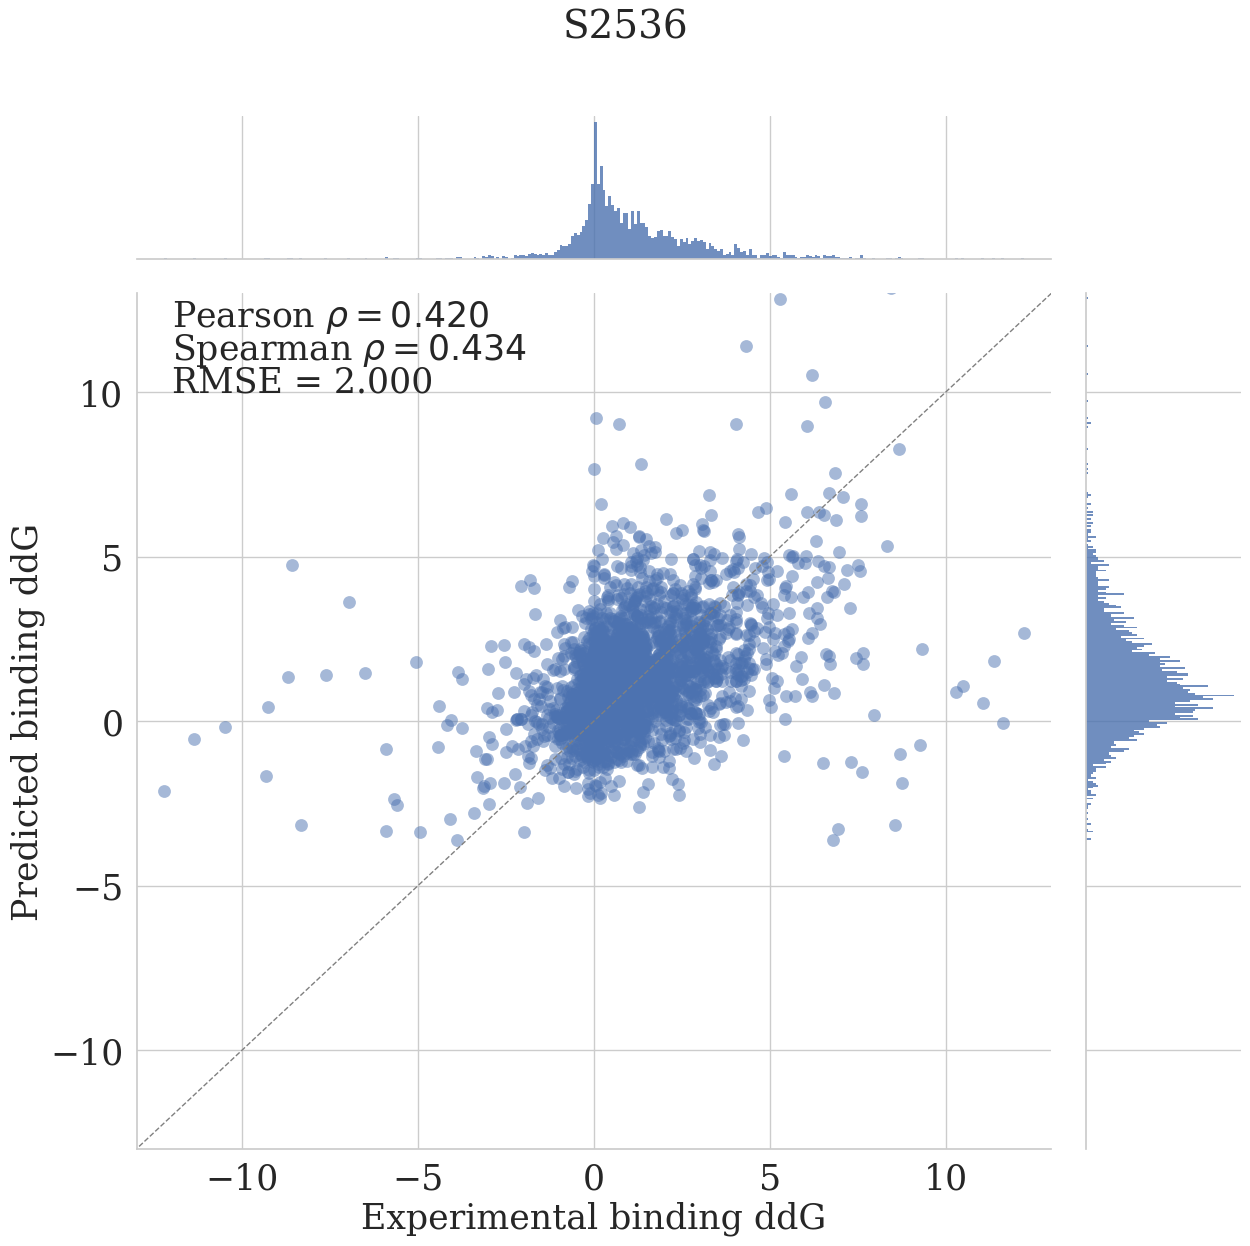

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df = S2536_sub.dropna(subset=['mean_ddG'])

# Set up the JointGrid
g = sns.JointGrid(data=df, x='DDGb', y='mean_ddG',
                  height=13,  # Adjust overall figure size
                  xlim=(-13, 13), ylim=(-13, 13))

#g = g.plot(sns.scatterplot, sns.kdeplot, alpha=0.5, linewidth=0, size=65)
g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=0, s=85)
# g.plot_marginals(sns.kdeplot, fill=True, alpha=0.6, linewidth=0)
g.plot_marginals(sns.histplot, fill=True, alpha=0.8, linewidth=0, bins=300)

# Add labels and title
g.set_axis_labels(xlabel='Experimental binding ddG', ylabel='Predicted binding ddG', fontsize=25)
g.fig.suptitle('S2536', fontsize=28, y=1) # Adjust suptitle position


# Add the diagonal line
min_val = -15 - 1.5
max_val = 15 + 1.5
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

# Calculate and annotate Pearson correlation coefficients
r_p, p_p = stats.pearsonr(df['DDGb'], df['mean_ddG'])
g.ax_joint.annotate(f"Pearson $\\rho = {r_p:.3f}$", xy=(-12, 12), fontsize = 25)

r_s, p_s = stats.spearmanr(df['DDGb'], df['mean_ddG'])
g.ax_joint.annotate(f'Spearman $\\rho = {r_s:.3f}$', xy=(-12, 11), fontsize = 25)

rmse = sqrt(mean_squared_error(df['DDGb'], df['mean_ddG']))
g.ax_joint.annotate(f'RMSE = {rmse:.3f}', xy=(-12, 10), fontsize = 25)

# # Add a legend to distinguish hue subgroups
# g.ax_joint.legend(title='Number of Mutations', fontsize=15, title_fontsize=18)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust rect to prevent suptitle overlap
#plt.savefig('Figures/S2536.pdf', format='pdf')

In [ ]:
residue_asa_3 = {
    'GLY': 47.155,
    'ALA': 61.063,
    'SER': 69.073,
    'CYS': 78.62,
    'PRO': 81.03,
    'THR': 82.92,
    'ASP': 86.142,
    'VAL': 90.264,
    'ASN': 90.541,
    'GLU': 102.57,
    'ILE': 105.307,
    'LEU': 105.842,
    'GLN': 106.534,
    'HIS': 110.864,
    'MET': 112.01,
    'LYS': 120.502,
    'PHE': 124.714,
    'TYR': 130.885,
    'ARG': 138.595,
    'TRP': 148.915
}

residue_asa_1 = {
    'G': 47.155,
    'A': 61.063,
    'S': 69.073,
    'C': 78.62,
    'P': 81.03,
    'T': 82.92,
    'D': 86.142,
    'V': 90.264,
    'N': 90.541,
    'E': 102.57,
    'I': 105.307,
    'L': 105.842,
    'Q': 106.534,
    'H': 110.864,
    'M': 112.01,
    'K': 120.502,
    'F': 124.714,
    'Y': 130.885,
    'R': 138.595,
    'W': 148.915
}

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15,15))
plt.setp(axes, xlim=(-13, 15.2), ylim=(-13, 15.2))
# Create the scatter plot
plot = sns.scatterplot(data=exp_cart_ddG_all_no_nan, x='mean_ddG',
                       y='mean_ddG_infc',
                       alpha=0.5, s=65, hue='N_mut')

plt.xlabel('Without IA', fontsize=25)
plt.ylabel('With IA', fontsize=25)
plt.title('Cartesian ddG vs Cartesian ddG + InterfaceAnalyzer', fontsize=25)

# Label the unfitting data points
x = exp_cart_ddG_all_no_nan['mean_ddG'].values
y = exp_cart_ddG_all_no_nan['mean_ddG_infc'].values
names = exp_cart_ddG_all_no_nan['variant'].values
txt_list=list()
for i in range(len(x)):
    # dist = np.sqrt((2*(abs(x-y))**2))/2
    dist = abs(x-y)
    sub_list = list()
    if (dist[i] > 4)&(len(names[i].split(':'))<=2):
        for point_mut in names[i].split(':'):
            sub_list.append(point_mut[-1])
        name = ','.join(sub_list)
        
        #plot.text(x[i]+0.01, y[i]+0.01, names[i][-1], fontsize=13)
        txt_list.append(plot.text(x[i]+0.01, y[i]+0.01, name, fontsize=10))
            
adjust_text(txt_list)

min_val = -15 - 1.5
max_val = 15 + 1.5
axes.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(exp_cart_ddG_all_no_nan['mean_ddG'],
                      exp_cart_ddG_all_no_nan['mean_ddG_infc'])
axes.annotate(f'all muts $\\rho = {r:.3f}$', xy=(5, -10), fontsize = 25)

r, p = stats.pearsonr(exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']=='1']['mean_ddG'],
                      exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['N_mut']=='1']['mean_ddG_infc'])
axes.annotate(f'single mut $\\rho = {r:.3f}$', xy=(5, -12), fontsize = 25)

#plt.savefig('Figures/cart_ddG_IA_vs_reg.pdf', format='pdf')

In [ ]:


fig, axes = plt.subplots(1,1, figsize = (12,12))
plt.setp(axes, xlim=(-13, 13), ylim=(-13, 13))
# Create the scatter plot

df = exp_cart_ddG_all_no_nan.loc[exp_cart_ddG_all_no_nan['no_proper_value']!='Regular']

plot = sns.scatterplot(data=df, x='ddG_bind',
                       y='mean_ddG_infc',
                       alpha=0.5, s=65, hue='no_proper_value')

plt.xlabel('Experimental binding ddG', fontsize=25)
plt.ylabel('Predicted binding ddG', fontsize=25)
plt.title('Cartesian ddG + InterfaceAnalyzer', fontsize=25)

min_val = -15 - 1.5
max_val = 15 + 1.5
axes.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

r, p = stats.pearsonr(df['ddG_bind'],
                      df['mean_ddG_infc'])
axes.annotate(f'all muts $\\rho = {r:.3f}$', xy=(0, -9), fontsize = 25)

r, p = stats.pearsonr(df.loc[df['N_mut']=='1']['ddG_bind'],
                      df.loc[df['N_mut']=='1']['mean_ddG_infc'])
axes.annotate(f'single mut $\\rho = {r:.3f}$', xy=(0, -10.5), fontsize = 25)

sns.move_legend(axes, "upper left")

#plt.savefig('Figures/cart_ddG_IA_no_outliers.pdf', format='pdf')

In [ ]:
skempi2_mm = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_multi_measurements.csv')
skempi2_mm_count = skempi2_mm[['#Pdb', 'Method']].groupby('Method').count().reset_index()
skempi2_mm_count.rename(columns={"#Pdb": "Percentage"}, inplace=True)
skempi2_mm_count['Percentage'] = skempi2_mm_count['Percentage'] / len(skempi2_mm) * 100
skempi2_mm_count['Subset'] = 'Multiple measuremnts' 

skempi2_mm_err = skempi2_mm.loc[skempi2_mm['ddG_bind_std']>1]
skempi2_mm_err_count = skempi2_mm_err[['#Pdb', 'Method']].groupby('Method').count().reset_index()
skempi2_mm_err_count.rename(columns={"#Pdb": "Percentage"}, inplace=True)
skempi2_mm_err_count['Percentage'] = skempi2_mm_err_count['Percentage'] / len(skempi2_mm_err) * 100
skempi2_mm_err_count['Subset'] = 'Error'

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

df = exp_cart_ddG_all_no_nan.copy()

# --- 1. Define Groups based on Prediction Error ---
# Here we use your exact logic to define the 'Outlier' group.
print("\n--- 2. Defining Groups ---")
df['Group'] = 'Non-Outlier'
df.loc[abs(df['ddG_bind']-df['mean_ddG_infc'])>4, 'Group'] = 'Outlier'

print(f"Total samples: {len(df)}")
print(f"Outlier samples: {len(df[df['Group'] == 'Outlier'])}")
print(f"Non-Outlier samples: {len(df[df['Group'] == 'Non-Outlier'])}")


# --- 2. Create the Contingency Table ---
# This table counts the occurrences of each 'Method' for each 'Group'.
print("\n--- 3. Building the Contingency Table ---")
contingency_table = pd.crosstab(df['Group'], df['Method'])
print(contingency_table)


# --- 3. Perform the Chi-Squared Test ---
print("\n--- 4. Performing Chi-Squared Test ---")
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nP-value: {p_value:.10f}")
if p_value < 0.05:
    print("Result: The p-value is significant. The distribution of 'Method' is different for the outlier group.")
else:
    print("Result: The p-value is not significant. The 'Method' distribution is similar across groups.")


# --- 4. Find Overrepresented Categories (Post-Hoc Analysis) ---
# If the p-value was significant, we find out which categories were responsible.
if p_value < 0.05:
    print("\n--- 5. Analyzing Standardized Residuals ---")
    # Standardized Residual = (Observed - Expected) / sqrt(Expected)
    residuals = (contingency_table - expected) / np.sqrt(expected)
    
    # Extracting the residuals for the 'Outlier' group for easier analysis
    outlier_residuals = residuals.loc['Outlier']
    
    # A residual > 1.96 is a common threshold for statistical significance
    overrepresented = outlier_residuals[outlier_residuals > 1.96]

    print("\nInterpreting the Residuals for the 'Outlier' group:")
    print("A large positive residual (> 1.96) suggests significant OVERREPRESENTATION.")
    
    if not overrepresented.empty:
        print("\nSignificantly OVERREPRESENTED categories in the Outlier group:")
        print(overrepresented.round(2))
    else:
        print("\nNo categories were found to be significantly overrepresented in the Outlier group.")